In [1]:
import sys
import os
import uproot
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats as st
import scipy

import peakutils

from datetime import datetime

import math
from scipy          import stats
from scipy.optimize import curve_fit

from scipy.signal import savgol_filter

from functools         import partial
from matplotlib.colors import LogNorm

In [2]:
### Import functions from peak_functions

repository_path = os.path.abspath('../..')
sys.path.append(repository_path)

import blr_functions  as blr
import peak_functions as pf
import fit_functions  as fitf

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
plt.rcParams["figure.figsize"] = 9, 6
plt.rcParams["font.size"]      = 14

In [5]:
import matplotlib
# Set Palatino as the serif font
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif']  = 'Palatino'

In [6]:
fav_col = '#418094'

In [7]:
filename2 = '/Users/romoluque_c/LEGEND/BACON/datatest/run-12_28_2023-file.root'
infile2   = uproot.open(filename2)
RawTree2  = infile2['RawTree']

max_smpl_bsl        = 650
std_bsl_thr         = 15
sg_filter_window    = 50
sg_filter_polyorder = 3
thr_ADC             = 50 #ths for the noise suppression and peak finder after SG filter
min_dist            = 50 #min distance between peaks for peakutils

#normal_chs  = range(9) Channel 5 is dead
normal_chs  = [0, 1, 2, 3, 4, 6, 7, 8]
trigger_chs = [9, 10, 11]

In [8]:
### Gains for the SG method

gains_sg = {0: 215.9136058765189,
            1: 197.6173531487562,
            2: 208.09116790825274,
            3: 201.34467649924105,
            4: 209.56593611368697,
            6: 212.5709132476739,
            7: 217.5102713630135,
            8: 211.7111175113524,
            9: 601.3149156238308,
            10: 588.0378833443852,
            11: 555.1266908913976}

In [9]:
subt_wfs_dict = {ch: pf.subtract_baseline(pf.wfs_from_rawtree(RawTree2, ch),
                                          mode=True,
                                          wf_range_bsl=(0, max_smpl_bsl))
                 for ch in normal_chs}

trigg_cwfs_dict = {ch: np.array([blr.pmt_deconvolver(wf, wf_range_bsl=(0, max_smpl_bsl))
                                 for wf in pf.wfs_from_rawtree(RawTree2, ch)])
                   for ch in trigger_chs}

sg_filt_swfs_dict = {ch: savgol_filter(subt_wfs_dict[ch],
                                       window_length=sg_filter_window,
                                       polyorder=sg_filter_polyorder)
                     for ch in normal_chs}

sg_filt_trigg_dict = {ch: savgol_filter(trigg_cwfs_dict[ch],
                                        window_length=sg_filter_window,
                                        polyorder=sg_filter_polyorder)
                      for ch in trigger_chs}


thr_spe = 0.5
zs_sg_filt_swfs_dict = {ch: pf.noise_suppression(sg_filt_swfs_dict[ch]/gains_sg[ch],
                                                 threshold=thr_spe)
                        for ch in normal_chs}

zs_sg_filt_trigg_dict = {ch: pf.noise_suppression(sg_filt_trigg_dict[ch]/gains_sg[ch],
                                                  threshold=thr_spe)
                         for ch in trigger_chs}

In [10]:
gains = {0:  228.78612544813345,
         1:  206.5098755175535,
         2:  221.70401991464104,
         3:  215.32349719234927,
         4:  224.9179650548769,
         5:  230.50715541568943,
         6:  226.72397898148785,
         7:  231.6381789944484,
         8:  225.59700099028822,
         9:  630.80392091,
         10: 621.89586331,
         11: 583.50579627}

In [11]:
zs_swfs_dict = {ch: pf.noise_suppression(subt_wfs_dict[ch]/gains[ch],
                                         threshold=thr_spe)
                        for ch in normal_chs}

zs_trigg_dict = {ch: pf.noise_suppression(trigg_cwfs_dict[ch]/gains[ch],
                                          threshold=thr_spe)
                         for ch in trigger_chs}

In [12]:
def get_index_and_heights(subt_wfs, zs_sg_filt_swfs, trigg_cwfs, zs_sg_filt_trigg, thres=thr_spe, min_dist=50, thres_abs=True):

    partial_get_peaks_peakutils_spe = partial(pf.get_peaks_peakutils, thres=thr_spe, min_dist=min_dist, thres_abs=thres_abs)
    
    idx_peaks_ch = {ch: np.array(list(map(partial_get_peaks_peakutils_spe, zs_sg_filt_swfs[ch])), dtype=object)
                         for ch in normal_chs}
    
    idx_peaks_thr_ch = {ch: np.array([pf.get_values_thr_from_zswf(wf, idx_peaks_ch[ch][i])
                                          for i,wf in enumerate(zs_sg_filt_swfs[ch])], dtype=object)
                             for ch in normal_chs}
    
    height_peaks_ch = {ch: np.array([wf[idx_peaks_ch[ch][i]] if len(idx_peaks_ch[ch][i])!=0 else np.array([])
                                                for i, wf in enumerate(subt_wfs[ch])], dtype=object)
                                  for ch in normal_chs}
    
    height_peaks_sg_ch = {ch: np.array([pf.peak_height(wf, idx_peaks_ch[ch][i])
                                          for i,wf in enumerate(zs_sg_filt_swfs[ch])], dtype=object)
                            for ch in normal_chs}
    
    #height_peaks_deconv_ch = {ch: np.array([pf.peak_height_deconv(wf,
    #                                                              idx_peaks_ch   [ch][i],
    #                                                              height_peaks_ch[ch][i].copy())
    #                               for i, wf in enumerate(zs_sg_filt_swfs[ch])], dtype=object)
    #                               for ch in normal_chs}
    
    height_peaks_sg_deconv_ch = {ch: np.array([pf.peak_height_deconv(wf,
                                                                     idx_peaks_ch      [ch][i],
                                                                     height_peaks_sg_ch[ch][i].copy())
                                   for i, wf in enumerate(zs_sg_filt_swfs[ch])], dtype=object)
                                   for ch in normal_chs}
    
    
    
    idx_peaks_ch_trigg = {ch: np.array(list(map(partial_get_peaks_peakutils_spe, zs_sg_filt_trigg[ch])), dtype=object)
                               for ch in trigger_chs}
    
    idx_peaks_thr_ch_trigg = {ch: np.array([pf.get_values_thr_from_zswf(wf, idx_peaks_ch_trigg[ch][i])
                                                for i,wf in enumerate(zs_sg_filt_trigg[ch])], dtype=object)
                                   for ch in trigger_chs}
    
    height_peaks_ch_trigg = {ch: np.array([wf[idx_peaks_ch_trigg[ch][i]] if len(idx_peaks_ch_trigg[ch][i])!=0 else np.array([])
                                                for i,wf in enumerate(trigg_cwfs[ch])], dtype=object)
                                  for ch in trigger_chs}
    
    height_peaks_sg_ch_trigg = {ch: np.array([pf.peak_height(wf, idx_peaks_ch_trigg[ch][i])
                                                   for i,wf in enumerate(zs_sg_filt_trigg[ch])], dtype=object)
                                     for ch in trigger_chs}
    
    #height_peaks_deconv_ch_trigg = {ch: np.array([pf.peak_height_deconv(wf,
    #                                                                    idx_peaks_ch_trigg   [ch][i],
    #                                                                    height_peaks_ch_trigg[ch][i].copy())
    #                                     for i, wf in enumerate(zs_sg_filt_trigg[ch])], dtype=object)
    #                                     for ch in trigger_chs}
    
    height_peaks_sg_deconv_ch_trigg = {ch: np.array([pf.peak_height_deconv(wf,
                                                                           idx_peaks_ch_trigg      [ch][i],
                                                                           height_peaks_sg_ch_trigg[ch][i].copy())
                                         for i, wf in enumerate(zs_sg_filt_trigg[ch])], dtype=object)
                                         for ch in trigger_chs}
    
    return idx_peaks_ch, idx_peaks_thr_ch, height_peaks_ch, height_peaks_sg_ch, height_peaks_sg_deconv_ch, idx_peaks_ch_trigg, idx_peaks_thr_ch_trigg, height_peaks_ch_trigg, height_peaks_sg_ch_trigg, height_peaks_sg_deconv_ch_trigg

In [13]:
_, idx_thr_10, _, _, h_sgd_10, _, idx_thr_trigg_10, _, _, h_sgd_trigg_10 = get_index_and_heights(subt_wfs_dict, zs_sg_filt_swfs_dict, trigg_cwfs_dict, zs_sg_filt_trigg_dict, thres=thr_spe, min_dist=10, thres_abs=True)
_, idx_thr_20, _, _, h_sgd_20, _, idx_thr_trigg_20, _, _, h_sgd_trigg_20 = get_index_and_heights(subt_wfs_dict, zs_sg_filt_swfs_dict, trigg_cwfs_dict, zs_sg_filt_trigg_dict, thres=thr_spe, min_dist=20, thres_abs=True)
_, idx_thr_30, _, _, h_sgd_30, _, idx_thr_trigg_30, _, _, h_sgd_trigg_30 = get_index_and_heights(subt_wfs_dict, zs_sg_filt_swfs_dict, trigg_cwfs_dict, zs_sg_filt_trigg_dict, thres=thr_spe, min_dist=30, thres_abs=True)
_, idx_thr_40, _, _, h_sgd_40, _, idx_thr_trigg_40, _, _, h_sgd_trigg_40 = get_index_and_heights(subt_wfs_dict, zs_sg_filt_swfs_dict, trigg_cwfs_dict, zs_sg_filt_trigg_dict, thres=thr_spe, min_dist=40, thres_abs=True)
_, idx_thr_50, _, _, h_sgd_50, _, idx_thr_trigg_50, _, _, h_sgd_trigg_50 = get_index_and_heights(subt_wfs_dict, zs_sg_filt_swfs_dict, trigg_cwfs_dict, zs_sg_filt_trigg_dict, thres=thr_spe, min_dist=50, thres_abs=True)

In [14]:
_, idx_thr_2_10, _, _, h_sgd_2_10, _, idx_thr_trigg_2_10, _, _, h_sgd_trigg_2_10 = get_index_and_heights(subt_wfs_dict, zs_swfs_dict, trigg_cwfs_dict, zs_trigg_dict, thres=thr_spe, min_dist=10, thres_abs=True)
_, idx_thr_2_20, _, _, h_sgd_2_20, _, idx_thr_trigg_2_20, _, _, h_sgd_trigg_2_20 = get_index_and_heights(subt_wfs_dict, zs_swfs_dict, trigg_cwfs_dict, zs_trigg_dict, thres=thr_spe, min_dist=20, thres_abs=True)
_, idx_thr_2_30, _, _, h_sgd_2_30, _, idx_thr_trigg_2_30, _, _, h_sgd_trigg_2_30 = get_index_and_heights(subt_wfs_dict, zs_swfs_dict, trigg_cwfs_dict, zs_trigg_dict, thres=thr_spe, min_dist=30, thres_abs=True)
_, idx_thr_2_40, _, _, h_sgd_2_40, _, idx_thr_trigg_2_40, _, _, h_sgd_trigg_2_40 = get_index_and_heights(subt_wfs_dict, zs_swfs_dict, trigg_cwfs_dict, zs_trigg_dict, thres=thr_spe, min_dist=40, thres_abs=True)
_, idx_thr_2_50, _, _, h_sgd_2_50, _, idx_thr_trigg_2_50, _, _, h_sgd_trigg_2_50 = get_index_and_heights(subt_wfs_dict, zs_swfs_dict, trigg_cwfs_dict, zs_trigg_dict, thres=thr_spe, min_dist=50, thres_abs=True)

In [15]:
def concat_indexes_and_heights(idx_thr, h_sgd, idx_thr_trigg, h_sgd_trigg, normal_SiPMs=True, trigger_SiPMs=True):
    idx_thr_all = []
    h_sgd_all   = []
    for evt in range(len(h_sgd[0])):
        qindex_all_ch = []
        qpeaks_all_ch = []
        if normal_SiPMs:
            for ch in normal_chs:
                for qindex, qpeak in zip(idx_thr[ch][evt], h_sgd[ch][evt]):
                    qindex_all_ch.append(qindex)
                    qpeaks_all_ch.append(qpeak)

        if trigger_SiPMs:
            for ch in trigger_chs:
                for qindex, qpeak in zip(idx_thr_trigg[ch][evt], h_sgd_trigg[ch][evt]):
                    qindex_all_ch.append(qindex)
                    qpeaks_all_ch.append(qpeak)
    
        idx_thr_all.append(np.array(qindex_all_ch))
        h_sgd_all  .append(np.array(qpeaks_all_ch))
    return idx_thr_all, h_sgd_all

In [16]:
idx_thr_10_all, h_sgd_10_all = concat_indexes_and_heights(idx_thr_10, h_sgd_10, idx_thr_trigg_10, h_sgd_trigg_10)
idx_thr_20_all, h_sgd_20_all = concat_indexes_and_heights(idx_thr_20, h_sgd_20, idx_thr_trigg_20, h_sgd_trigg_20)
idx_thr_30_all, h_sgd_30_all = concat_indexes_and_heights(idx_thr_30, h_sgd_30, idx_thr_trigg_30, h_sgd_trigg_30)
idx_thr_40_all, h_sgd_40_all = concat_indexes_and_heights(idx_thr_40, h_sgd_40, idx_thr_trigg_40, h_sgd_trigg_40)
idx_thr_50_all, h_sgd_50_all = concat_indexes_and_heights(idx_thr_50, h_sgd_50, idx_thr_trigg_50, h_sgd_trigg_50)

In [17]:
len(idx_thr_10_all[0])

5

In [18]:
idx_thr_2_10_all, h_sgd_2_10_all = concat_indexes_and_heights(idx_thr_2_10, h_sgd_2_10, idx_thr_trigg_2_10, h_sgd_trigg_2_10)
idx_thr_2_20_all, h_sgd_2_20_all = concat_indexes_and_heights(idx_thr_2_20, h_sgd_2_20, idx_thr_trigg_2_20, h_sgd_trigg_2_20)
idx_thr_2_30_all, h_sgd_2_30_all = concat_indexes_and_heights(idx_thr_2_30, h_sgd_2_30, idx_thr_trigg_2_30, h_sgd_trigg_2_30)
idx_thr_2_40_all, h_sgd_2_40_all = concat_indexes_and_heights(idx_thr_2_40, h_sgd_2_40, idx_thr_trigg_2_40, h_sgd_trigg_2_40)
idx_thr_2_50_all, h_sgd_2_50_all = concat_indexes_and_heights(idx_thr_2_50, h_sgd_2_50, idx_thr_trigg_2_50, h_sgd_trigg_2_50)

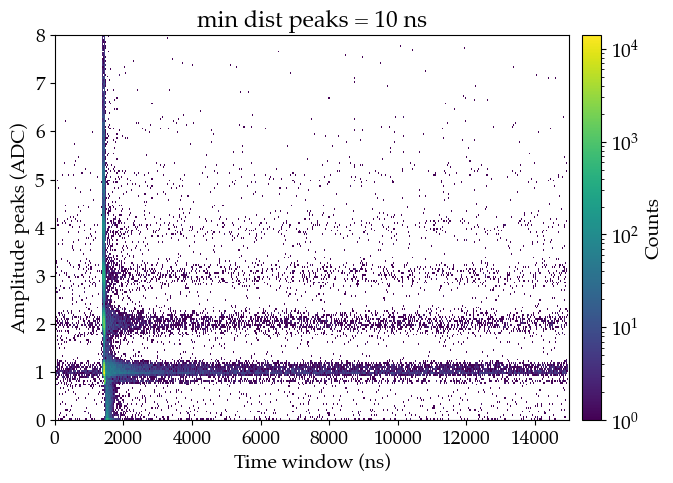

In [19]:
fig = plt.figure(figsize=(8, 5))
h = plt.hist2d(np.concatenate(idx_thr_10_all)*2, np.concatenate(h_sgd_10_all), bins=(500, 200), range=((0, 15000), (0, 8)), cmin=1, norm=LogNorm())
plt.title('min dist peaks = 10 ns')
plt.xlabel('Time window (ns)',      fontsize=14)
plt.ylabel('Amplitude peaks (ADC)', fontsize=14)
plt.colorbar(h[3], label='Counts', pad=0.02)
plt.show()

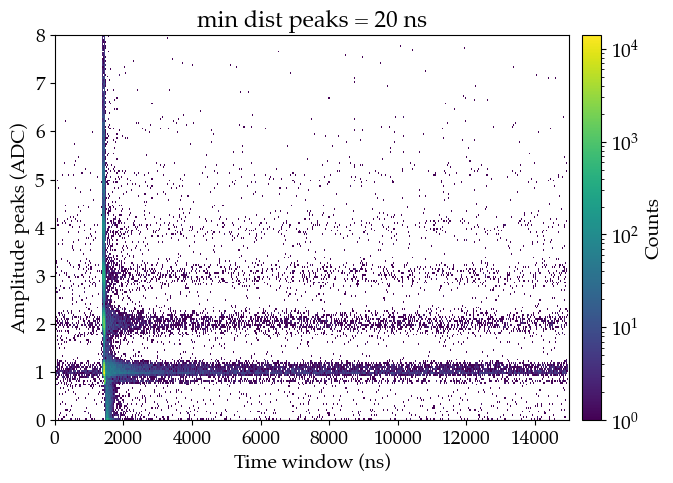

In [20]:
fig = plt.figure(figsize=(8, 5))
h = plt.hist2d(np.concatenate(idx_thr_20_all)*2, np.concatenate(h_sgd_20_all), bins=(500, 200), range=((0, 15000), (0, 8)), cmin=1, norm=LogNorm())
plt.title('min dist peaks = 20 ns')
plt.xlabel('Time window (ns)',      fontsize=14)
plt.ylabel('Amplitude peaks (ADC)', fontsize=14)
plt.colorbar(h[3], label='Counts', pad=0.02)
plt.show()

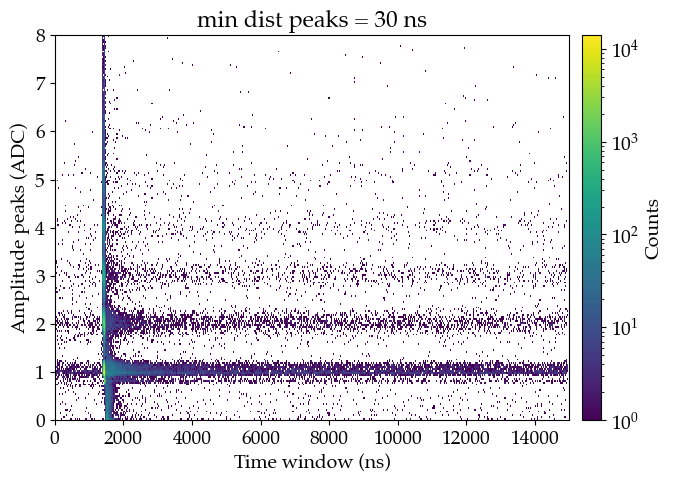

In [21]:
fig = plt.figure(figsize=(8, 5))
h = plt.hist2d(np.concatenate(idx_thr_30_all)*2, np.concatenate(h_sgd_30_all), bins=(500, 200), range=((0, 15000), (0, 8)), cmin=1, norm=LogNorm())
plt.title('min dist peaks = 30 ns')
plt.xlabel('Time window (ns)',      fontsize=14)
plt.ylabel('Amplitude peaks (ADC)', fontsize=14)
plt.colorbar(h[3], label='Counts', pad=0.02)
plt.show()

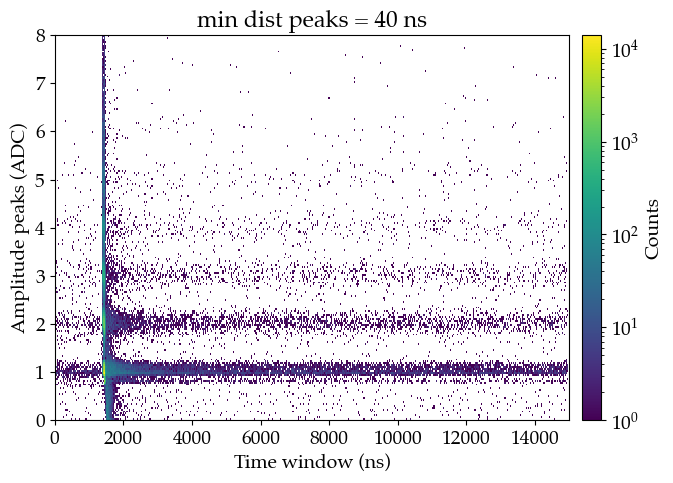

In [22]:
fig = plt.figure(figsize=(8, 5))
h = plt.hist2d(np.concatenate(idx_thr_40_all)*2, np.concatenate(h_sgd_40_all), bins=(500, 200), range=((0, 15000), (0, 8)), cmin=1, norm=LogNorm())
plt.title('min dist peaks = 40 ns')
plt.xlabel('Time window (ns)',      fontsize=14)
plt.ylabel('Amplitude peaks (ADC)', fontsize=14)
plt.colorbar(h[3], label='Counts', pad=0.02)
plt.show()

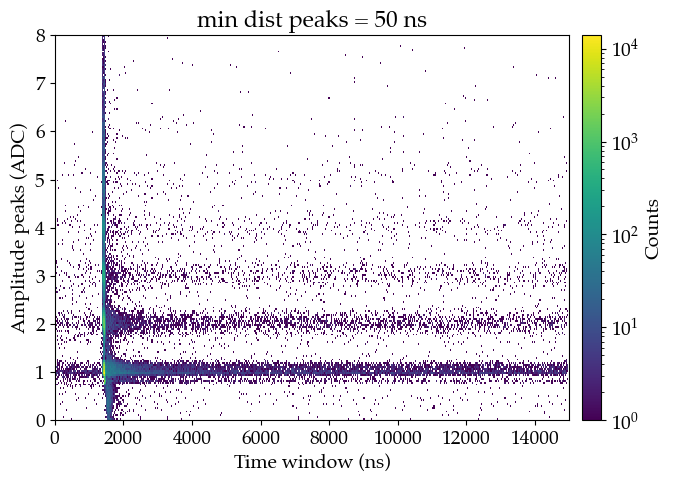

In [23]:
fig = plt.figure(figsize=(8, 5))
h = plt.hist2d(np.concatenate(idx_thr_50_all)*2, np.concatenate(h_sgd_50_all), bins=(500, 200), range=((0, 15000), (0, 8)), cmin=1, norm=LogNorm())
plt.title('min dist peaks = 50 ns')
plt.xlabel('Time window (ns)',      fontsize=14)
plt.ylabel('Amplitude peaks (ADC)', fontsize=14)
plt.colorbar(h[3], label='Counts', pad=0.02)
plt.show()

In [24]:
all_idxes    = [idx_thr_10_all, idx_thr_20_all, idx_thr_30_all, idx_thr_40_all, idx_thr_50_all]
all_heights  = [h_sgd_10_all,   h_sgd_20_all,   h_sgd_30_all,   h_sgd_40_all,   h_sgd_50_all]
all_idxes2   = [2*np.concatenate(idx)  for idx  in all_idxes]
all_heights2 = [  np.concatenate(heig) for heig in all_heights]

all_sum_hits = []
for idata, hdata in zip(all_idxes2, all_heights2):
    sum_hits = []
    for time_bin in range(0, 15000, 2):
        sum_hits.append(np.sum(hdata[np.where((idata==time_bin))]))
    all_sum_hits.append(np.array(sum_hits))

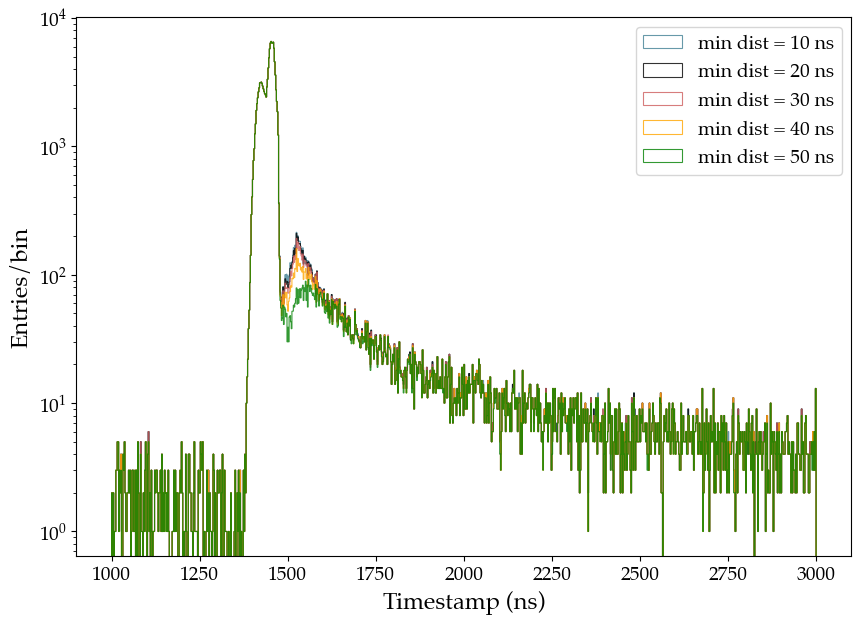

In [25]:
fig = plt.figure(figsize=(10, 7))
for min_d, idata, col in zip(range(10, 60, 10), all_idxes, [fav_col, 'k', 'indianred', 'orange', 'green']):
    plt.hist(2*np.concatenate(idata), bins=1000, range=(1000, 3000), log=True, histtype='step', linewidth=0.8, label=f'min dist = {min_d} ns', alpha=0.8, color=col)
plt.xlabel('Timestamp (ns)', fontsize=17)
plt.ylabel('Entries/bin',    fontsize=17)
plt.legend()
#plt.xlim(1000, 3000)
plt.show()

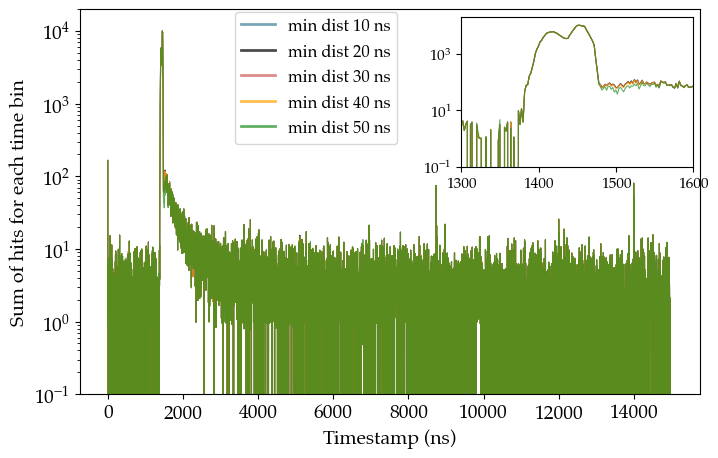

In [26]:
fig = plt.figure(figsize=(8, 5))
for sum_h, min_d, col in zip(all_sum_hits, range(10, 60, 10), [fav_col, 'k', 'indianred', 'orange', 'forestgreen']):
    plt.plot(range(0, 15000, 2), sum_h, lw=0.8, label=f'min dist {min_d} ns', color=col, alpha=0.7)
plt.xlabel('Timestamp (ns)')
plt.ylabel('Sum of hits for each time bin')
leg = plt.legend(loc=(0.25, 0.65), fontsize=12)
for line in leg.get_lines():
    line.set_linewidth(2)

plt.yscale('log')
plt.ylim(1e-1, 2e4)

ax_inset = fig.add_axes([0.602, 0.565, 0.29, 0.30])
for sum_h, min_d, col in zip(all_sum_hits, range(10, 60, 10), [fav_col, 'k', 'indianred', 'orange', 'forestgreen']):
    ax_inset.plot(range(0, 15000, 2), sum_h, lw=0.8, color=col, alpha=0.7)
ax_inset.set_xlim(1300, 1600)
ax_inset.set_yscale('log')
ax_inset.set_ylim(1e-1, 2e4)
ax_inset.tick_params(axis='x', labelsize=11)
ax_inset.tick_params(axis='y', labelsize=11)
plt.show()

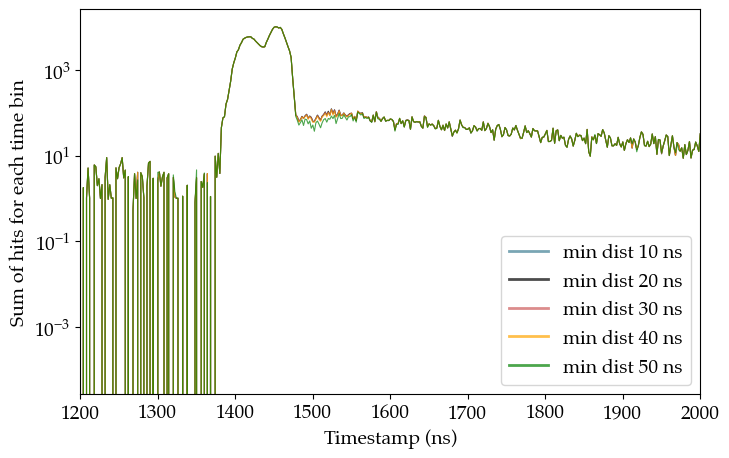

In [27]:
fig = plt.figure(figsize=(8, 5))
for sum_h, min_d, col in zip(all_sum_hits, range(10, 60, 10), [fav_col, 'k', 'indianred', 'orange', 'green']):
    plt.plot(range(0, 15000, 2), sum_h, lw=0.8, label=f'min dist {min_d} ns', color=col, alpha=0.7)
plt.xlabel('Timestamp (ns)')
plt.ylabel('Sum of hits for each time bin')
leg = plt.legend(loc='lower right')
for line in leg.get_lines():
    line.set_linewidth(2)
plt.yscale('log')
plt.xlim(1200, 2000)
plt.show()

In [28]:
idx_thr_10_norm, h_sgd_10_norm = concat_indexes_and_heights(idx_thr_10, h_sgd_10, idx_thr_trigg_10, h_sgd_trigg_10, trigger_SiPMs=False)
idx_thr_20_norm, h_sgd_20_norm = concat_indexes_and_heights(idx_thr_20, h_sgd_20, idx_thr_trigg_20, h_sgd_trigg_20, trigger_SiPMs=False)
idx_thr_30_norm, h_sgd_30_norm = concat_indexes_and_heights(idx_thr_30, h_sgd_30, idx_thr_trigg_30, h_sgd_trigg_30, trigger_SiPMs=False)
idx_thr_40_norm, h_sgd_40_norm = concat_indexes_and_heights(idx_thr_40, h_sgd_40, idx_thr_trigg_40, h_sgd_trigg_40, trigger_SiPMs=False)
idx_thr_50_norm, h_sgd_50_norm = concat_indexes_and_heights(idx_thr_50, h_sgd_50, idx_thr_trigg_50, h_sgd_trigg_50, trigger_SiPMs=False)

all_idxes_normal    = [idx_thr_10_norm, idx_thr_20_norm, idx_thr_30_norm, idx_thr_40_norm, idx_thr_50_norm]
all_heights_normal  = [h_sgd_10_norm,   h_sgd_20_norm,   h_sgd_30_norm,   h_sgd_40_norm,   h_sgd_50_norm]
all_idxes2_normal   = [2*np.concatenate(idx)  for idx  in all_idxes_normal]
all_heights2_normal = [  np.concatenate(heig) for heig in all_heights_normal]

all_sum_hits_normal = []
for idata, hdata in zip(all_idxes2_normal, all_heights2_normal):
    all_sum_hits_normal.append(np.array([np.sum(hdata[idata==time_bin]) for time_bin in range(0, 15000, 2)]))


idx_thr_10_trig, h_sgd_10_trig = concat_indexes_and_heights(idx_thr_10, h_sgd_10, idx_thr_trigg_10, h_sgd_trigg_10, normal_SiPMs=False)
idx_thr_20_trig, h_sgd_20_trig = concat_indexes_and_heights(idx_thr_20, h_sgd_20, idx_thr_trigg_20, h_sgd_trigg_20, normal_SiPMs=False)
idx_thr_30_trig, h_sgd_30_trig = concat_indexes_and_heights(idx_thr_30, h_sgd_30, idx_thr_trigg_30, h_sgd_trigg_30, normal_SiPMs=False)
idx_thr_40_trig, h_sgd_40_trig = concat_indexes_and_heights(idx_thr_40, h_sgd_40, idx_thr_trigg_40, h_sgd_trigg_40, normal_SiPMs=False)
idx_thr_50_trig, h_sgd_50_trig = concat_indexes_and_heights(idx_thr_50, h_sgd_50, idx_thr_trigg_50, h_sgd_trigg_50, normal_SiPMs=False)

all_idxes_trigger    = [idx_thr_10_trig, idx_thr_20_trig, idx_thr_30_trig, idx_thr_40_trig, idx_thr_50_trig]
all_heights_trigger  = [h_sgd_10_trig,   h_sgd_20_trig,   h_sgd_30_trig,   h_sgd_40_trig,   h_sgd_50_trig]
all_idxes2_trigger   = [2*np.concatenate(idx)  for idx  in all_idxes_trigger]
all_heights2_trigger = [  np.concatenate(heig) for heig in all_heights_trigger]

all_sum_hits_trigger = []
for idata, hdata in zip(all_idxes2_trigger, all_heights2_trigger):
    all_sum_hits_trigger.append(np.array([np.sum(hdata[idata==time_bin]) for time_bin in range(0, 15000, 2)]))

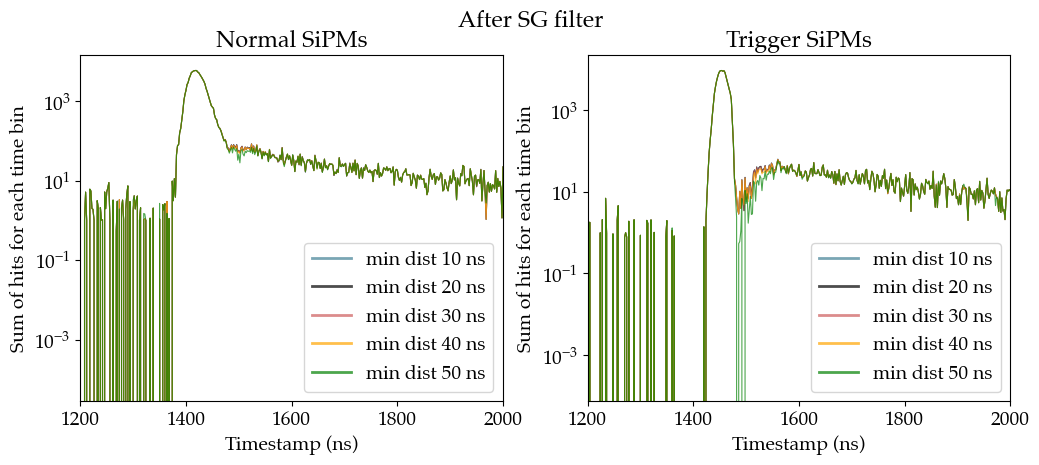

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4.5))
for sum_h, min_d, col in zip(all_sum_hits_normal, range(10, 60, 10), [fav_col, 'k', 'indianred', 'orange', 'green']):
    axs[0].plot(range(0, 15000, 2), sum_h, lw=0.8, label=f'min dist {min_d} ns', color=col, alpha=0.7)
for sum_h, min_d, col in zip(all_sum_hits_trigger, range(10, 60, 10), [fav_col, 'k', 'indianred', 'orange', 'green']):
    axs[1].plot(range(0, 15000, 2), sum_h, lw=0.8, label=f'min dist {min_d} ns', color=col, alpha=0.7)

for ax, title in zip(axs, ['Normal SiPMs', 'Trigger SiPMs']):
    ax.set_xlabel('Timestamp (ns)')
    ax.set_ylabel('Sum of hits for each time bin')
    leg = ax.legend(loc='lower right')
    for line in leg.get_lines():
        line.set_linewidth(2)
    ax.set_yscale('log')
    ax.set_xlim(1200, 2000)
    ax.set_title(title)
fig.suptitle('After SG filter')
plt.show()

### Without SG filter

In [30]:
all_idxes    = [idx_thr_2_10_all, idx_thr_2_20_all, idx_thr_2_30_all, idx_thr_2_40_all, idx_thr_2_50_all]
all_heights  = [h_sgd_2_10_all,   h_sgd_2_20_all,   h_sgd_2_30_all,   h_sgd_2_40_all,   h_sgd_2_50_all]
all_idxes2   = [2*np.concatenate(idx)  for idx  in all_idxes]
all_heights2 = [  np.concatenate(heig) for heig in all_heights]

all_sum_hits = []
for idata, hdata in zip(all_idxes2, all_heights2):
    all_sum_hits.append(np.array([np.sum(hdata[idata==timestamp]) for timestamp in range(0, 15000, 2)]))

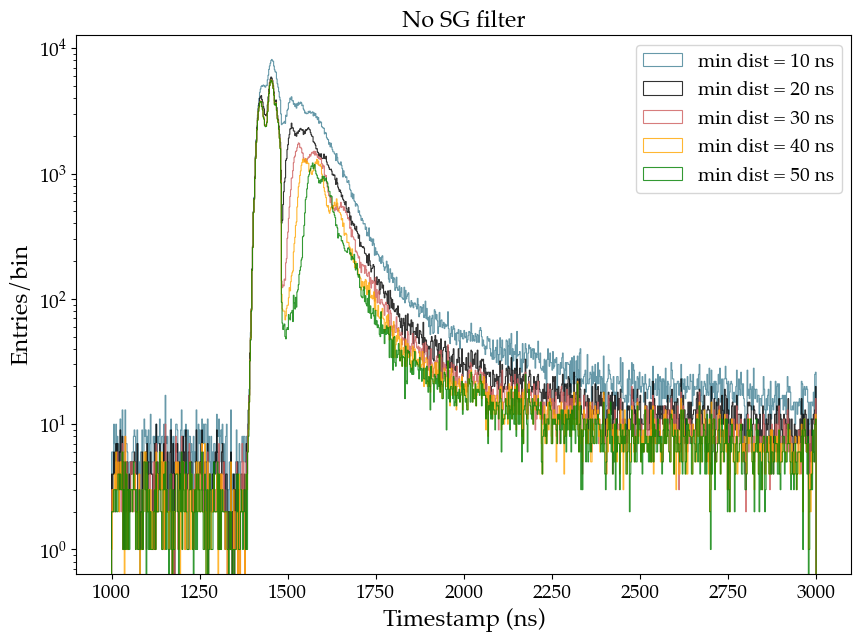

In [31]:
fig = plt.figure(figsize=(10, 7))
for min_d, idata, col in zip(range(10, 60, 10), all_idxes, [fav_col, 'k', 'indianred', 'orange', 'green']):
    plt.hist(2*np.concatenate(idata), bins=1000, range=(1000, 3000), log=True, histtype='step', linewidth=0.8, label=f'min dist = {min_d} ns', alpha=0.8, color=col)
plt.title('No SG filter')
plt.xlabel('Timestamp (ns)', fontsize=17)
plt.ylabel('Entries/bin',    fontsize=17)
plt.legend()
#plt.xlim(1000, 3000)
plt.show()

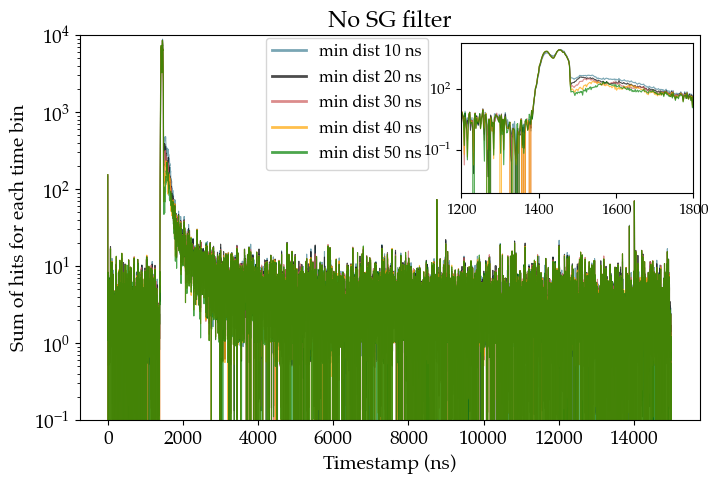

In [32]:
fig = plt.figure(figsize=(8, 5))
for sum_h, min_d, col in zip(all_sum_hits, range(10, 60, 10), [fav_col, 'k', 'indianred', 'orange', 'green']):
    plt.plot(range(0, 15000, 2), sum_h, lw=0.8, label=f'min dist {min_d} ns', color=col, alpha=0.7)
plt.title('No SG filter')
plt.xlabel('Timestamp (ns)')
plt.ylabel('Sum of hits for each time bin')
leg = plt.legend(loc=(0.3, 0.65), fontsize=12)
for line in leg.get_lines():
    line.set_linewidth(2)

plt.yscale('log')
plt.ylim(1e-1, 1e4)

ax_inset = fig.add_axes([0.602, 0.565, 0.29, 0.30])
for sum_h, min_d, col in zip(all_sum_hits, range(10, 60, 10), [fav_col, 'k', 'indianred', 'orange', 'green']):
    ax_inset.plot(range(0, 15000, 2), sum_h, lw=0.8, color=col, alpha=0.7)
ax_inset.set_xlim(1200, 1800)
ax_inset.set_yscale('log')
ax_inset.tick_params(axis='x', labelsize=11)
ax_inset.tick_params(axis='y', labelsize=11)
plt.show()

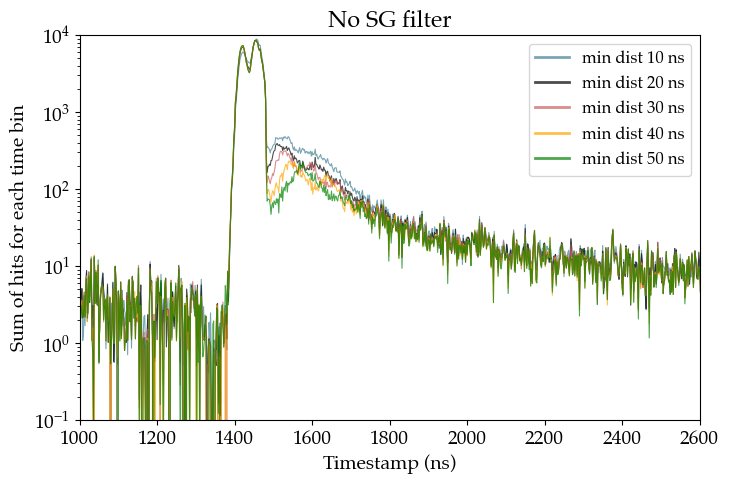

In [33]:
fig = plt.figure(figsize=(8, 5))
for sum_h, min_d, col in zip(all_sum_hits, range(10, 60, 10), [fav_col, 'k', 'indianred', 'orange', 'green']):
    plt.plot(range(0, 15000, 2), sum_h, lw=0.8, label=f'min dist {min_d} ns', color=col, alpha=0.7)
plt.title('No SG filter')
plt.xlabel('Timestamp (ns)')
plt.ylabel('Sum of hits for each time bin')
leg = plt.legend(fontsize=12)
for line in leg.get_lines():
    line.set_linewidth(2)

plt.yscale('log')
plt.ylim(1e-1, 1e4)
plt.xlim(1000, 2600)
plt.show()

In [34]:
idx_thr_10_norm2, h_sgd_10_norm2 = concat_indexes_and_heights(idx_thr_2_10, h_sgd_2_10, idx_thr_trigg_2_10, h_sgd_trigg_2_10, trigger_SiPMs=False)
idx_thr_20_norm2, h_sgd_20_norm2 = concat_indexes_and_heights(idx_thr_2_20, h_sgd_2_20, idx_thr_trigg_2_20, h_sgd_trigg_2_20, trigger_SiPMs=False)
idx_thr_30_norm2, h_sgd_30_norm2 = concat_indexes_and_heights(idx_thr_2_30, h_sgd_2_30, idx_thr_trigg_2_30, h_sgd_trigg_2_30, trigger_SiPMs=False)
idx_thr_40_norm2, h_sgd_40_norm2 = concat_indexes_and_heights(idx_thr_2_40, h_sgd_2_40, idx_thr_trigg_2_40, h_sgd_trigg_2_40, trigger_SiPMs=False)
idx_thr_50_norm2, h_sgd_50_norm2 = concat_indexes_and_heights(idx_thr_2_50, h_sgd_2_50, idx_thr_trigg_2_50, h_sgd_trigg_2_50, trigger_SiPMs=False)

all_idxes_norm2    = [idx_thr_10_norm2, idx_thr_20_norm2, idx_thr_30_norm2, idx_thr_40_norm2, idx_thr_50_norm2]
all_heights_norm2  = [h_sgd_10_norm2,   h_sgd_20_norm2,   h_sgd_30_norm2,   h_sgd_40_norm2,   h_sgd_50_norm2]
all_idxes2_norm2   = [2*np.concatenate(idx)  for idx  in all_idxes_norm2]
all_heights2_norm2 = [  np.concatenate(heig) for heig in all_heights_norm2]

all_sum_hits_norm2 = []
for idata, hdata in zip(all_idxes2_norm2, all_heights2_norm2):
    all_sum_hits_norm2.append(np.array([np.sum(hdata[idata==time_bin]) for time_bin in range(0, 15000, 2)]))


idx_thr_10_trig2, h_sgd_10_trig2 = concat_indexes_and_heights(idx_thr_2_10, h_sgd_2_10, idx_thr_trigg_2_10, h_sgd_trigg_2_10, normal_SiPMs=False)
idx_thr_20_trig2, h_sgd_20_trig2 = concat_indexes_and_heights(idx_thr_2_20, h_sgd_2_20, idx_thr_trigg_2_20, h_sgd_trigg_2_20, normal_SiPMs=False)
idx_thr_30_trig2, h_sgd_30_trig2 = concat_indexes_and_heights(idx_thr_2_30, h_sgd_2_30, idx_thr_trigg_2_30, h_sgd_trigg_2_30, normal_SiPMs=False)
idx_thr_40_trig2, h_sgd_40_trig2 = concat_indexes_and_heights(idx_thr_2_40, h_sgd_2_40, idx_thr_trigg_2_40, h_sgd_trigg_2_40, normal_SiPMs=False)
idx_thr_50_trig2, h_sgd_50_trig2 = concat_indexes_and_heights(idx_thr_2_50, h_sgd_2_50, idx_thr_trigg_2_50, h_sgd_trigg_2_50, normal_SiPMs=False)

all_idxes_trigg2    = [idx_thr_10_trig2, idx_thr_20_trig2, idx_thr_30_trig2, idx_thr_40_trig2, idx_thr_50_trig2]
all_heights_trigg2  = [h_sgd_10_trig2,   h_sgd_20_trig2,   h_sgd_30_trig2,   h_sgd_40_trig2,   h_sgd_50_trig2]
all_idxes2_trigg2   = [2*np.concatenate(idx)  for idx  in all_idxes_trigg2]
all_heights2_trigg2 = [  np.concatenate(heig) for heig in all_heights_trigg2]

all_sum_hits_trigg2 = []
for idata, hdata in zip(all_idxes2_trigg2, all_heights2_trigg2):
    all_sum_hits_trigg2.append(np.array([np.sum(hdata[idata==time_bin]) for time_bin in range(0, 15000, 2)]))

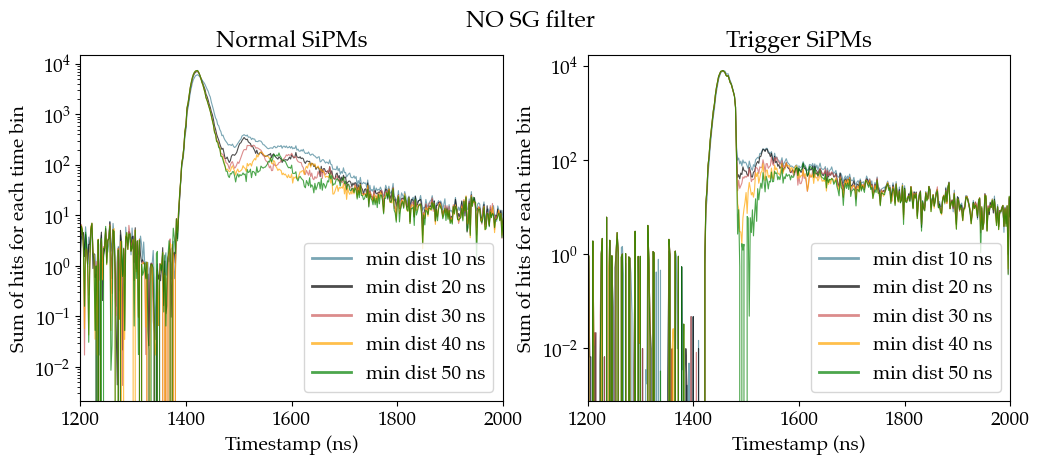

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4.5))
for sum_h, min_d, col in zip(all_sum_hits_norm2, range(10, 60, 10), [fav_col, 'k', 'indianred', 'orange', 'green']):
    axs[0].plot(range(0, 15000, 2), sum_h, lw=0.8, label=f'min dist {min_d} ns', color=col, alpha=0.7)
for sum_h, min_d, col in zip(all_sum_hits_trigg2, range(10, 60, 10), [fav_col, 'k', 'indianred', 'orange', 'green']):
    axs[1].plot(range(0, 15000, 2), sum_h, lw=0.8, label=f'min dist {min_d} ns', color=col, alpha=0.7)

for ax, title in zip(axs, ['Normal SiPMs', 'Trigger SiPMs']):
    ax.set_xlabel('Timestamp (ns)')
    ax.set_ylabel('Sum of hits for each time bin')
    leg = ax.legend(loc='lower right')
    for line in leg.get_lines():
        line.set_linewidth(2)
    ax.set_yscale('log')
    ax.set_xlim(1200, 2000)
    ax.set_title(title)
fig.suptitle('NO SG filter')
plt.show()

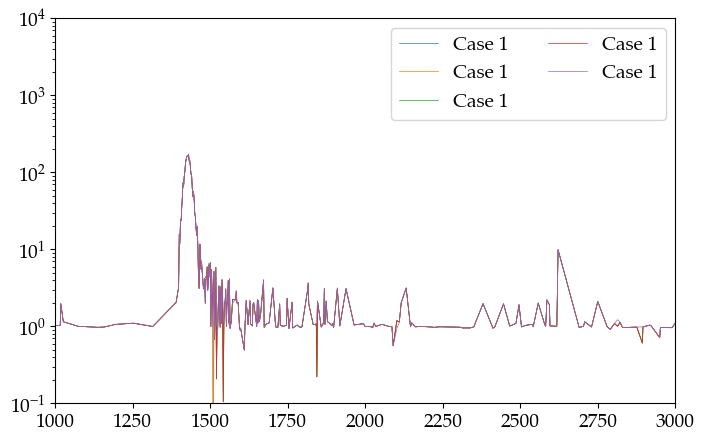

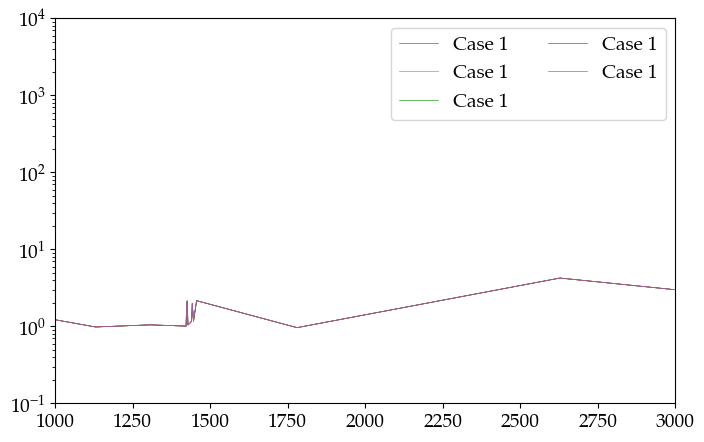

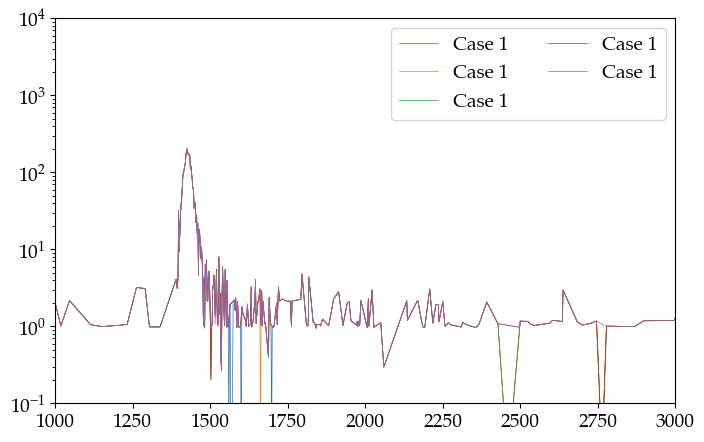

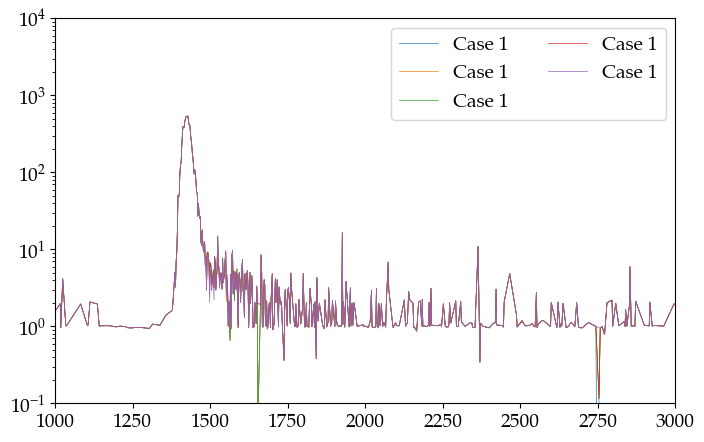

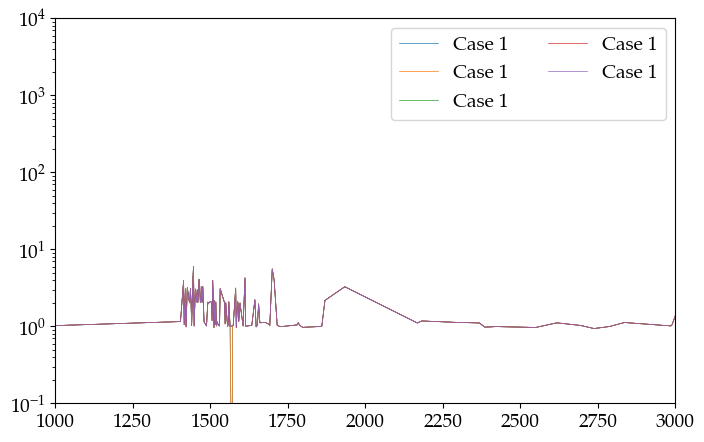

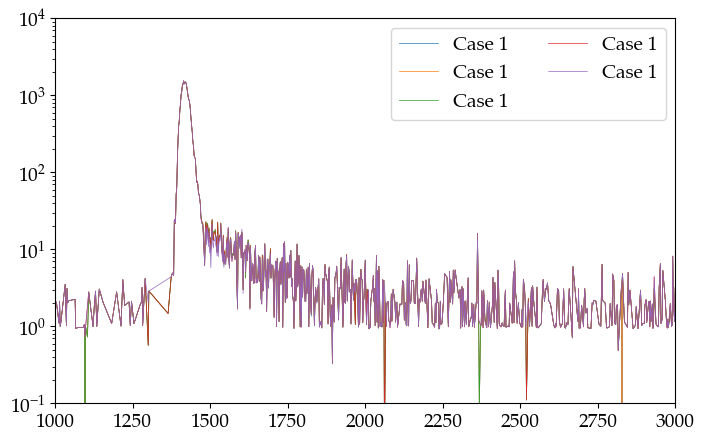

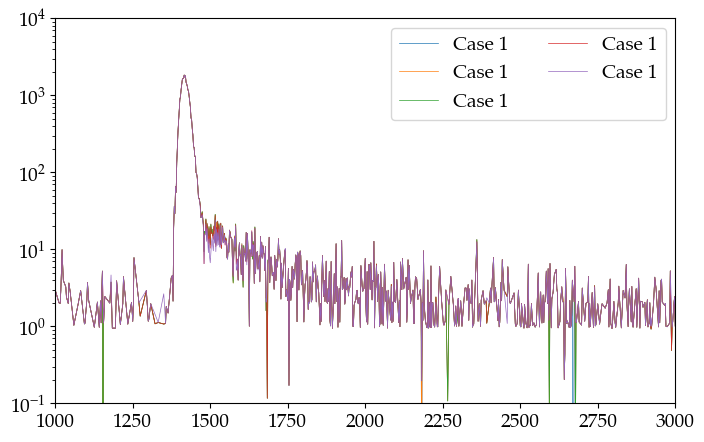

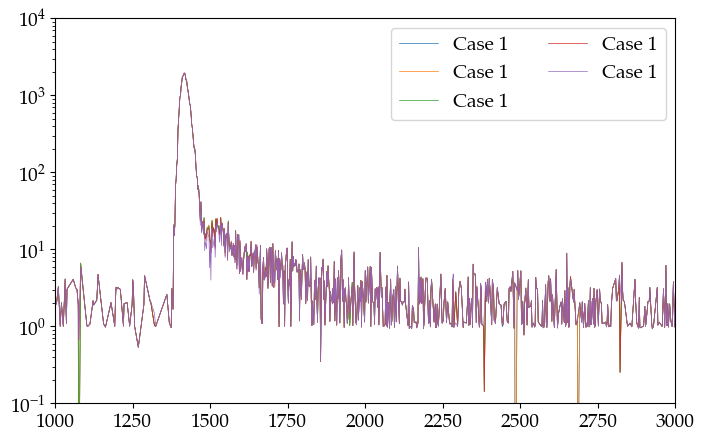

In [36]:
for channel in range(9):
    if channel==5:
        continue
    fig = plt.figure(figsize=(8, 5))
    for h,i in zip([h_sgd_10, h_sgd_20, h_sgd_30, h_sgd_40, h_sgd_50], [idx_thr_10, idx_thr_20, idx_thr_30, idx_thr_40, idx_thr_50]):
    
        ampl0  =   np.concatenate(h[channel])
        times0 = 2*np.concatenate(i[channel])
        
        sum_ampl0 = [np.sum(ampl0[times0==timestamp]) for timestamp in np.unique(times0)]
        plt.plot(np.unique(times0), sum_ampl0, lw=0.5, label=f'Case 1')

    plt.legend(ncol=2)
    plt.yscale('log')
    plt.xlim(1000, 3000)
    plt.ylim(1e-1, 1e4)

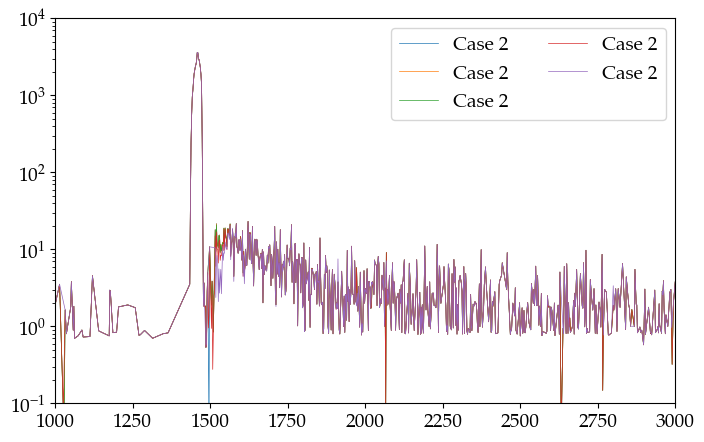

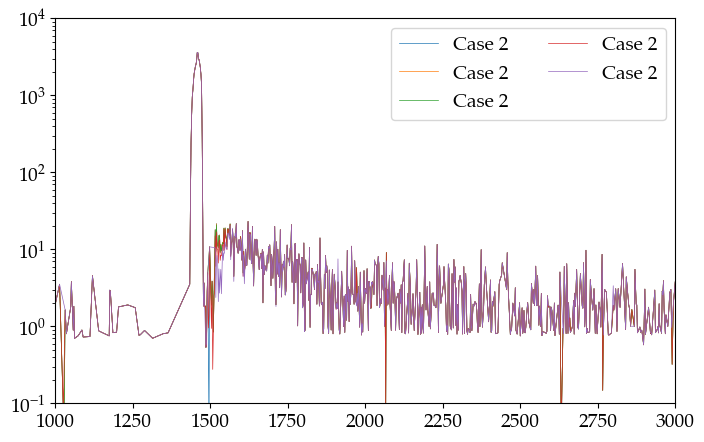

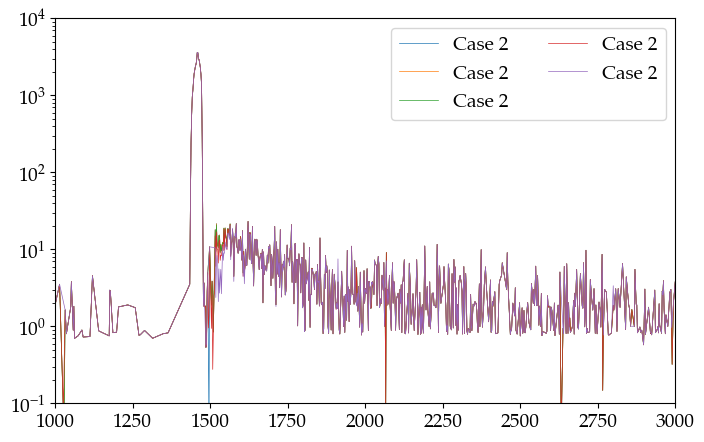

In [37]:
for channel in range(9, 12):
    fig = plt.figure(figsize=(8, 5))
    for h,i in zip([h_sgd_trigg_10, h_sgd_trigg_20, h_sgd_trigg_30, h_sgd_trigg_40, h_sgd_trigg_50], [idx_thr_trigg_10, idx_thr_trigg_20, idx_thr_trigg_30, idx_thr_trigg_40, idx_thr_trigg_50]):
    
        ampl0  =   np.concatenate(h[9])
        times0 = 2*np.concatenate(i[9])
        
        sum_ampl0 = [np.sum(ampl0[times0==timestamp]) for timestamp in np.unique(times0)]
        plt.plot(np.unique(times0), sum_ampl0, lw=0.5, label=f'Case 2')

    plt.legend(ncol=2)
    plt.yscale('log')
    plt.xlim(1000, 3000)
    plt.ylim(1e-1, 1e4)

## Check if the SG filter hide convoluted peaks:

In [38]:
filename = '/Users/romoluque_c/LEGEND/BACON/datatest/run-11_20_2023-file_1.root'
infile   = uproot.open(filename)
RawTree  = infile['RawTree']

In [39]:
filt_wfs_dict0 = {ch: np.array([(evt, wf)
                  for evt, wf in enumerate(pf.wfs_from_rawtree(RawTree, ch)) if np.std(wf) > 15], dtype=object)
                  for ch in normal_chs}

In [40]:
subt_wfs_dict0 = {ch: np.array([pf.subtract_baseline(fwf,
                                                     mode=True,
                                                     wf_range_bsl=(0, 650))
                      for _, fwf in filt_wfs_dict0[ch]])
                 if len(filt_wfs_dict0[ch])!=0 else []
                 for ch in normal_chs}

In [41]:
sg_filt_swfs_dict0 = {ch: savgol_filter(subt_wfs_dict0[ch],
                                        window_length=sg_filter_window,
                                        polyorder=sg_filter_polyorder)
                     if len(subt_wfs_dict0[ch]) != 0 else []
                     for ch in normal_chs}

In [42]:
sg_filt_swfs_dict30 = {ch: savgol_filter(subt_wfs_dict0[ch],
                                        window_length=30,
                                        polyorder=sg_filter_polyorder)
                     if len(subt_wfs_dict0[ch]) != 0 else []
                     for ch in normal_chs}

sg_filt_swfs_dict20 = {ch: savgol_filter(subt_wfs_dict0[ch],
                                        window_length=20,
                                        polyorder=sg_filter_polyorder)
                     if len(subt_wfs_dict0[ch]) != 0 else []
                     for ch in normal_chs}

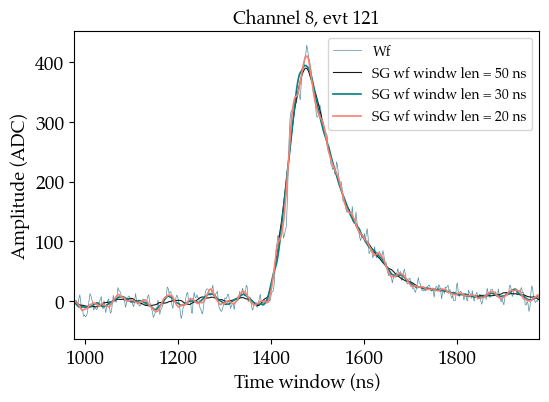

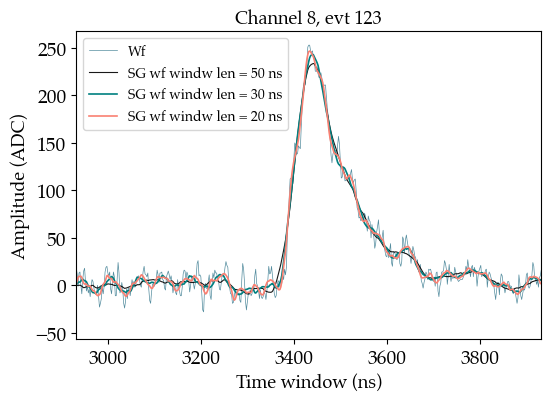

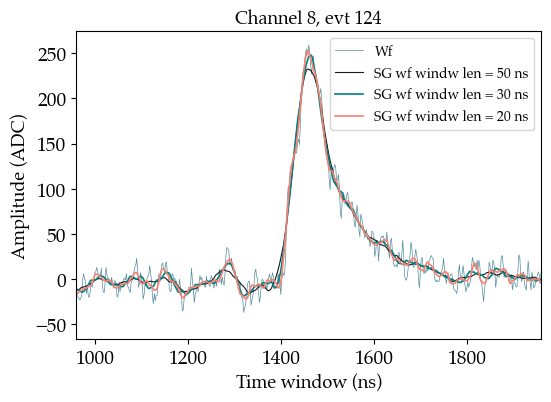

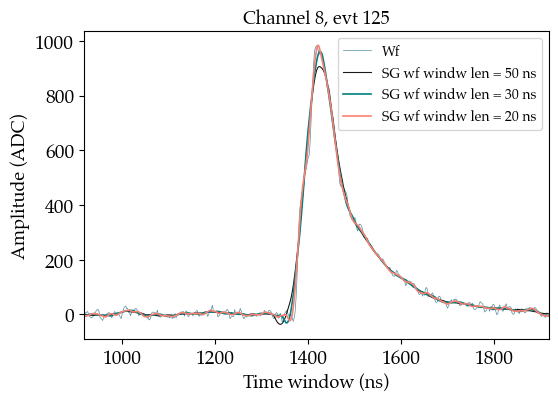

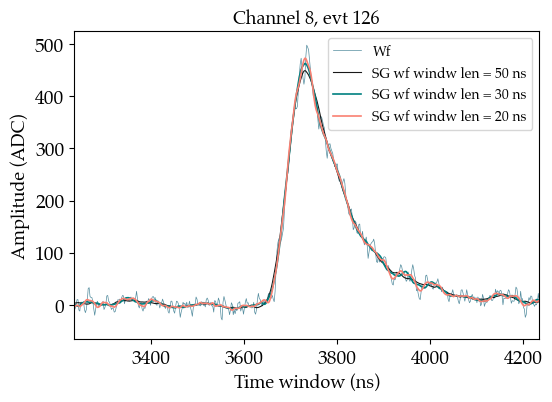

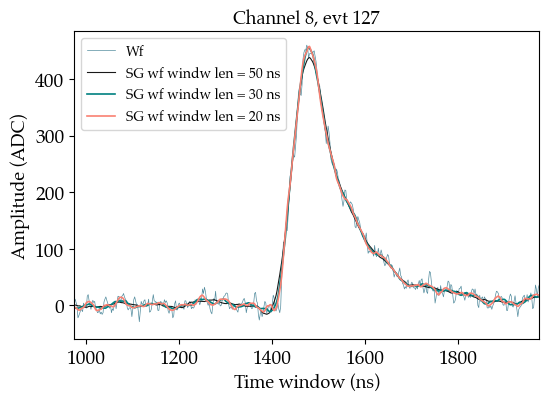

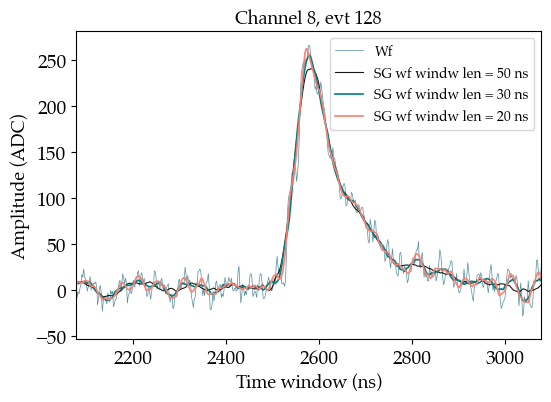

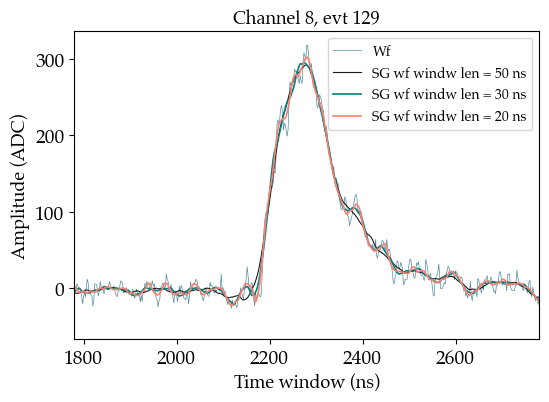

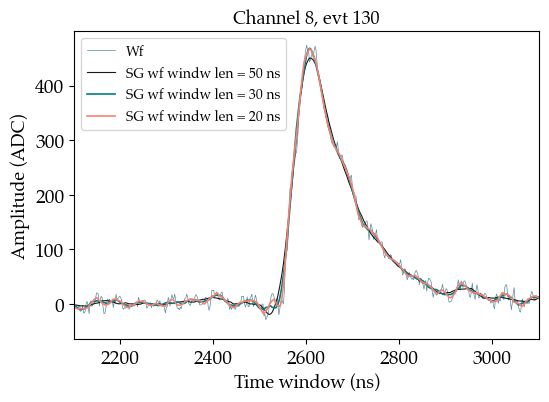

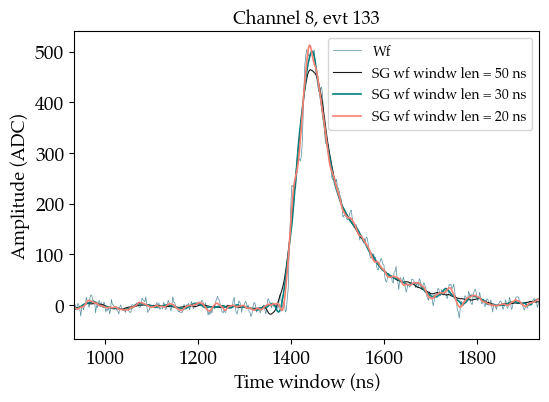

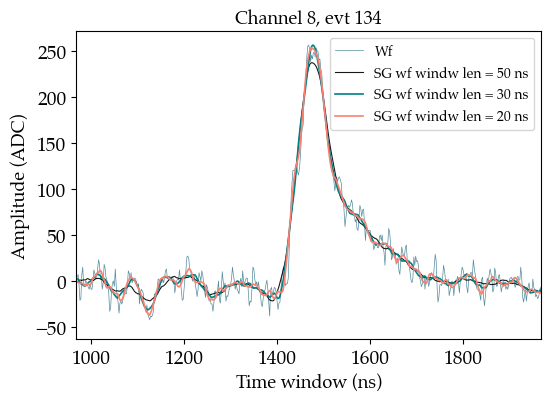

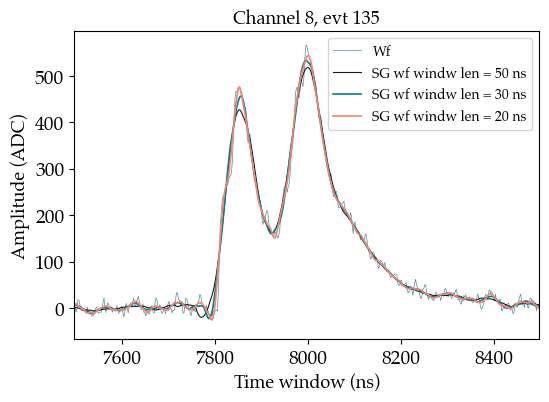

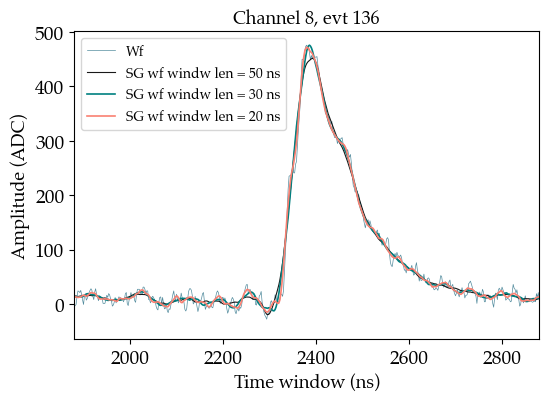

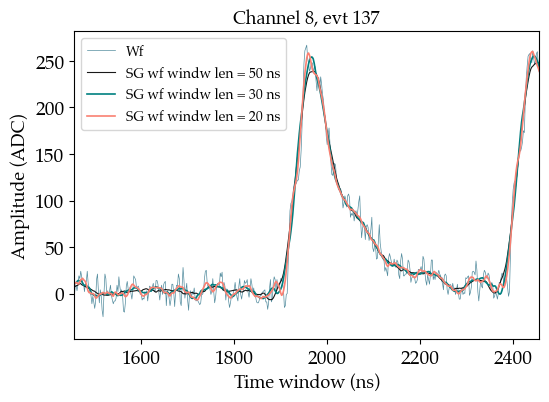

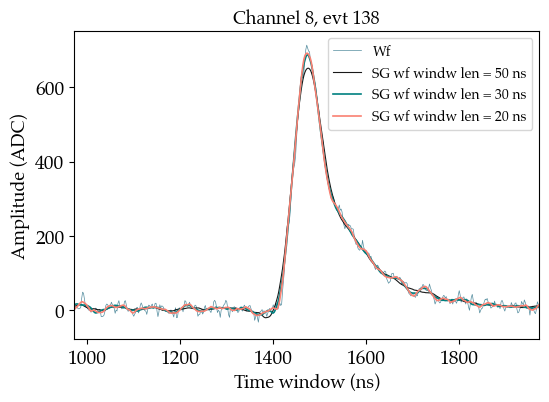

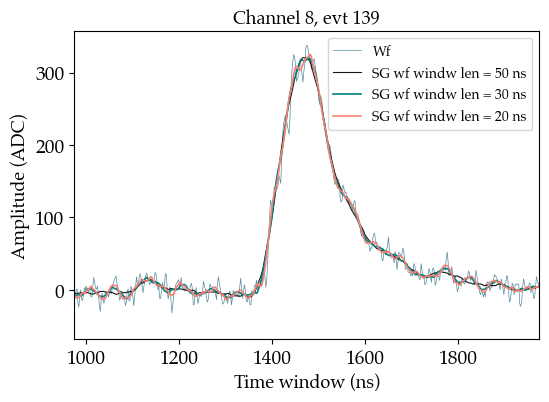

In [44]:
sel_ch   = 8
ievt     = 120
num_evts = 20
for evt, (swf, fswf, fswf30, fswf20) in enumerate(zip(subt_wfs_dict0[sel_ch][ievt:ievt+num_evts], sg_filt_swfs_dict0[sel_ch][ievt:ievt+num_evts], sg_filt_swfs_dict30[sel_ch][ievt:ievt+num_evts], sg_filt_swfs_dict20[sel_ch][ievt:ievt+num_evts])):
    #if evt in [3, 4, 6, 10, 12, 18, 25, 31, 58, 60, 63, 67, 68, 82, 92]:
    if np.std(swf)>20:
        evt     = evt + ievt
        max_idx = 2*np.argmax(swf)
        plt.figure(figsize=(6, 4))
        plt.plot(2*np.arange(len(swf)),    swf,    lw=0.5, label='Wf', c=fav_col,  alpha=0.9)
        plt.plot(2*np.arange(len(fswf)),   fswf,   lw=0.8, label='SG wf windw len = 50 ns', c='k',      alpha=0.9)
        plt.plot(2*np.arange(len(fswf30)), fswf30, lw=1.2, label='SG wf windw len = 30 ns', c='teal')
        plt.plot(2*np.arange(len(fswf20)), fswf20, lw=1.2, label='SG wf windw len = 20 ns', c='salmon')
        plt.xlabel('Time window (ns)', fontsize=13)
        plt.ylabel('Amplitude (ADC)',  fontsize=13)
        plt.title(f"Channel {sel_ch}, evt {evt}",     fontsize=13)
        plt.xlim(max_idx-500, max_idx+500)
        plt.legend(fontsize=10)
        plt.show()

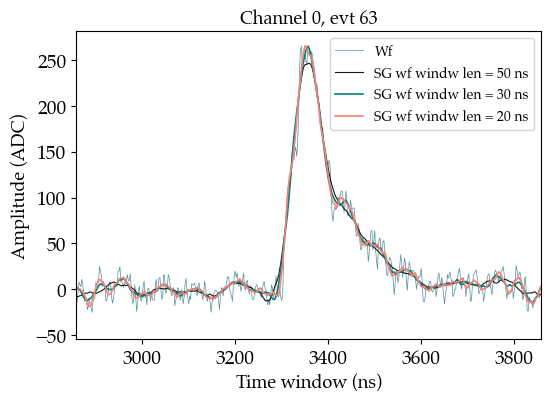

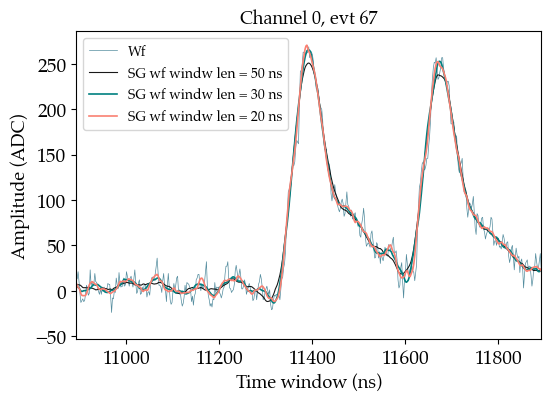

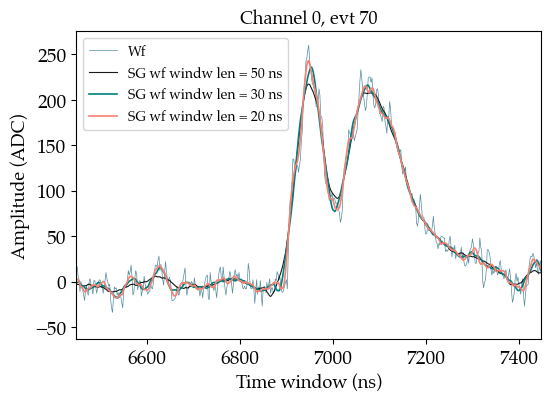

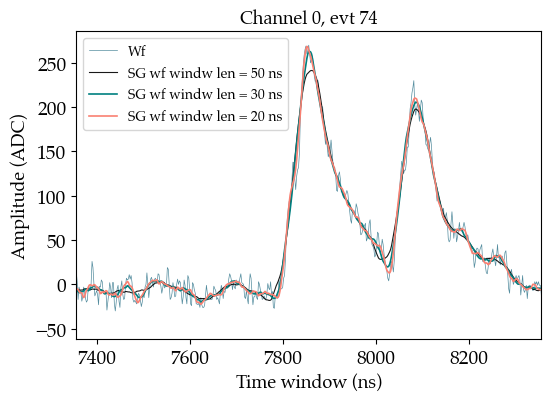

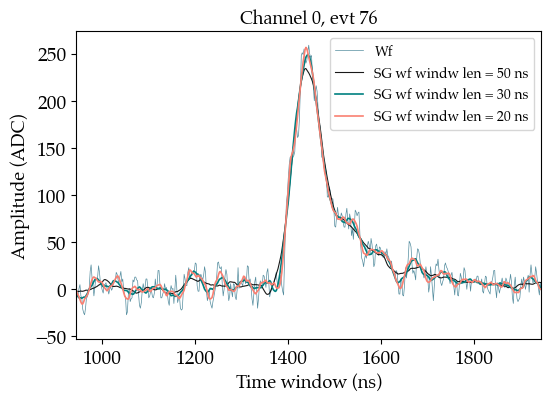

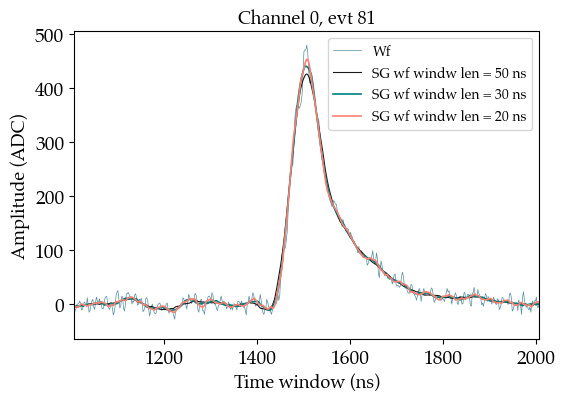

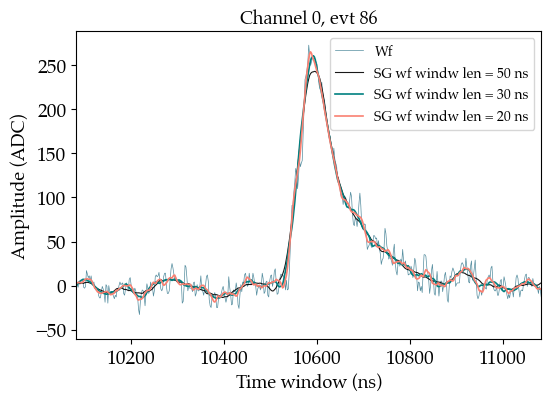

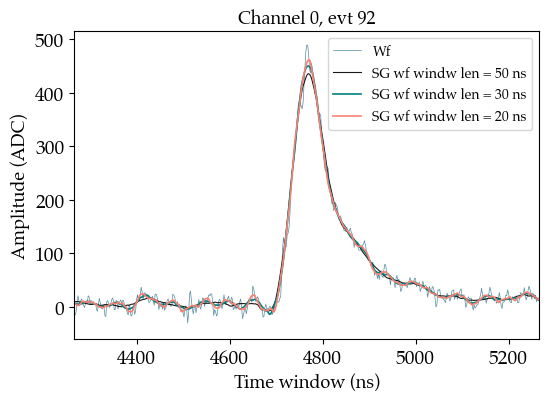

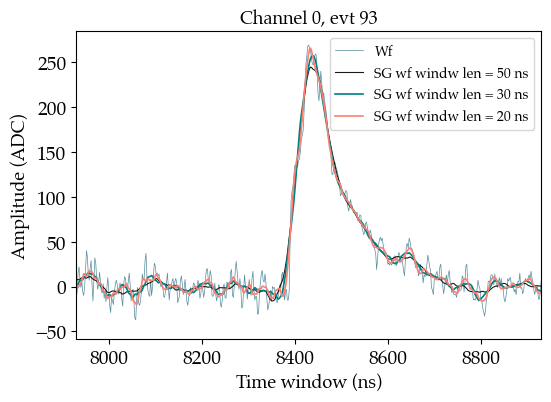

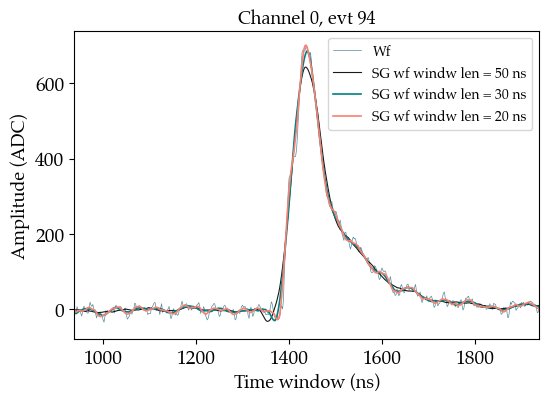

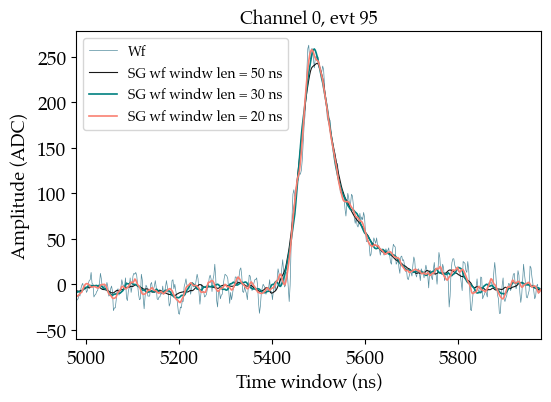

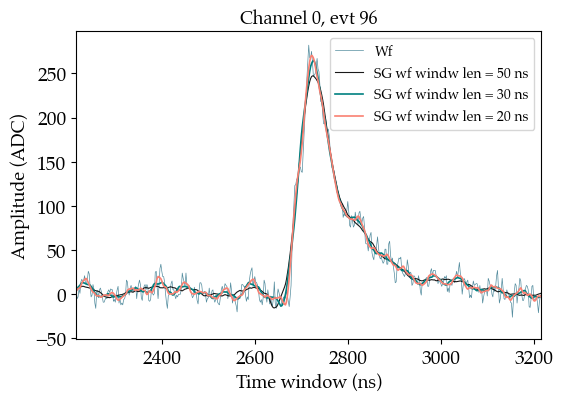

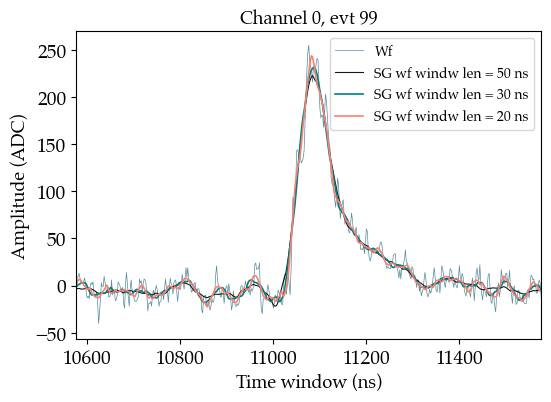

In [45]:
sel_ch   = 0
ievt     = 60
num_evts = 40
for evt, (swf, fswf, fswf30, fswf20) in enumerate(zip(subt_wfs_dict0[sel_ch][ievt:ievt+num_evts], sg_filt_swfs_dict0[sel_ch][ievt:ievt+num_evts], sg_filt_swfs_dict30[sel_ch][ievt:ievt+num_evts], sg_filt_swfs_dict20[sel_ch][ievt:ievt+num_evts])):
    #if evt in [3, 4, 6, 10, 12, 18, 25, 31, 58, 60, 63, 67, 68, 82, 92]:
    if np.std(swf)>20:
        evt     = evt + ievt
        max_idx = 2*np.argmax(swf)
        plt.figure(figsize=(6, 4))
        plt.plot(2*np.arange(len(swf)),    swf,    lw=0.5, label='Wf', c=fav_col,  alpha=0.9)
        plt.plot(2*np.arange(len(fswf)),   fswf,   lw=0.8, label='SG wf windw len = 50 ns', c='k',      alpha=0.9)
        plt.plot(2*np.arange(len(fswf30)), fswf30, lw=1.2, label='SG wf windw len = 30 ns', c='teal')
        plt.plot(2*np.arange(len(fswf20)), fswf20, lw=1.2, label='SG wf windw len = 20 ns', c='salmon')
        plt.xlabel('Time window (ns)', fontsize=13)
        plt.ylabel('Amplitude (ADC)',  fontsize=13)
        plt.title(f"Channel {sel_ch}, evt {evt}",     fontsize=13)
        plt.xlim(max_idx-500, max_idx+500)
        plt.legend(fontsize=10)
        plt.show()

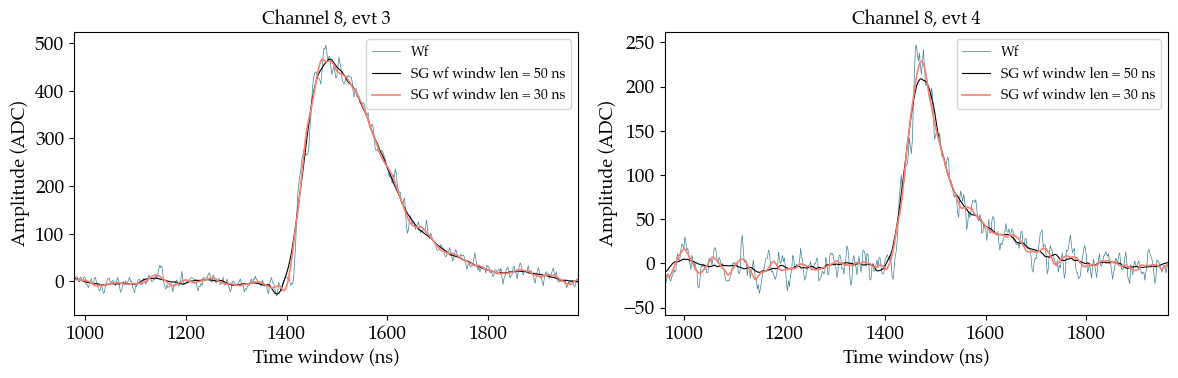

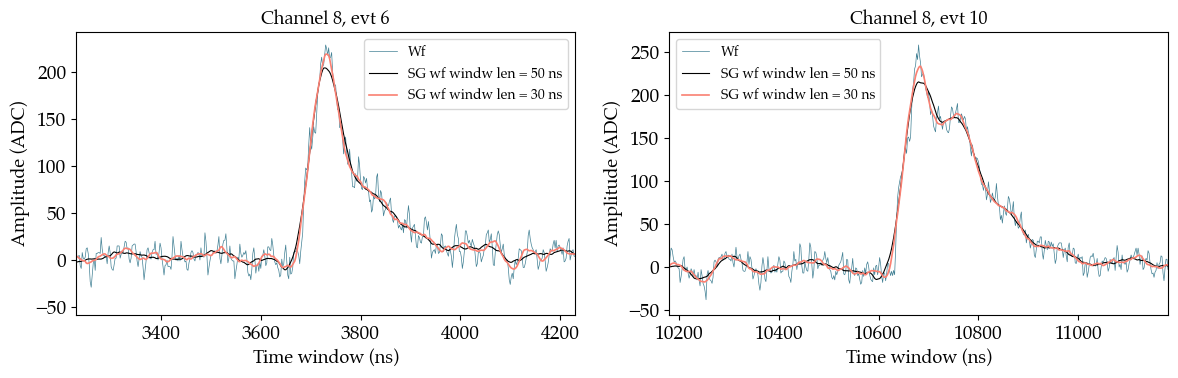

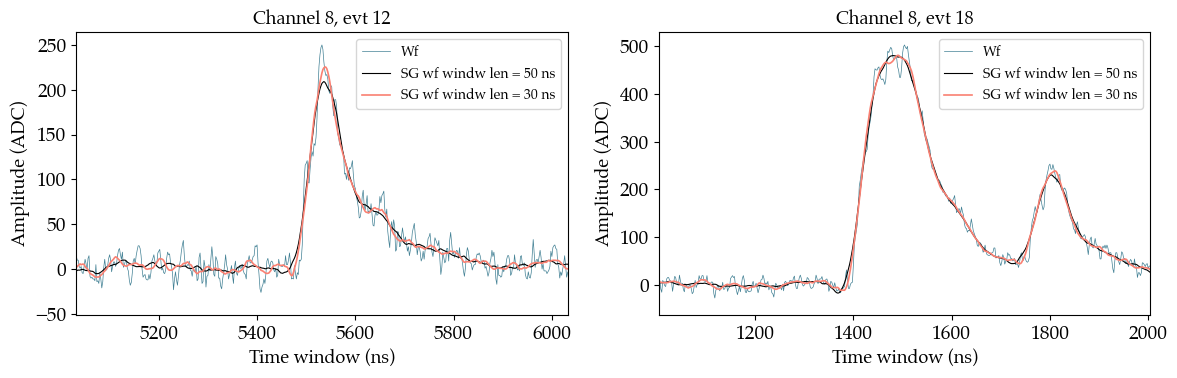

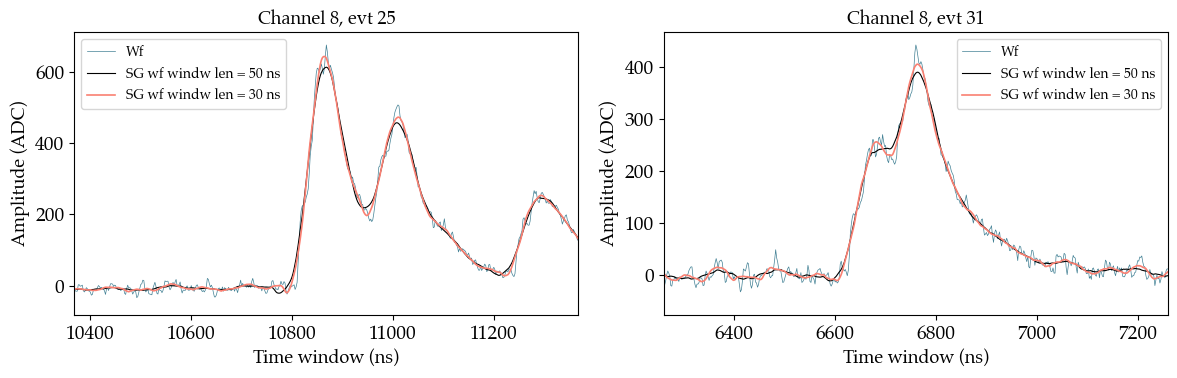

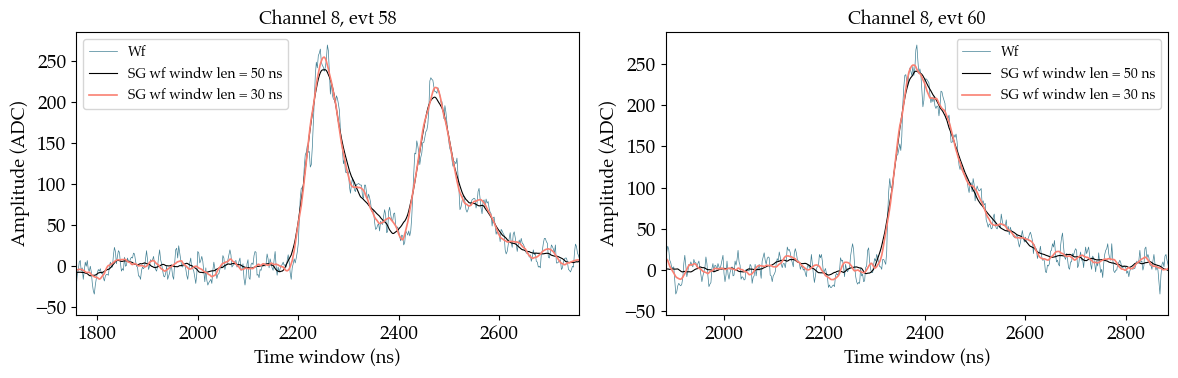

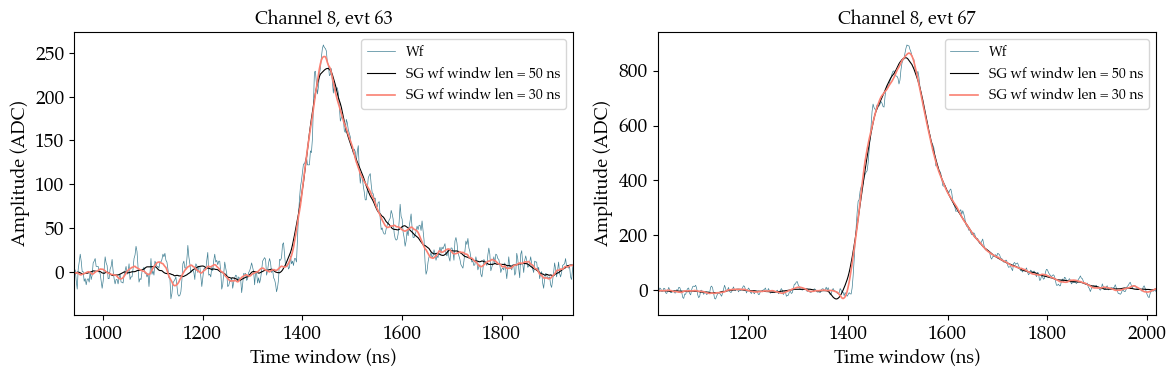

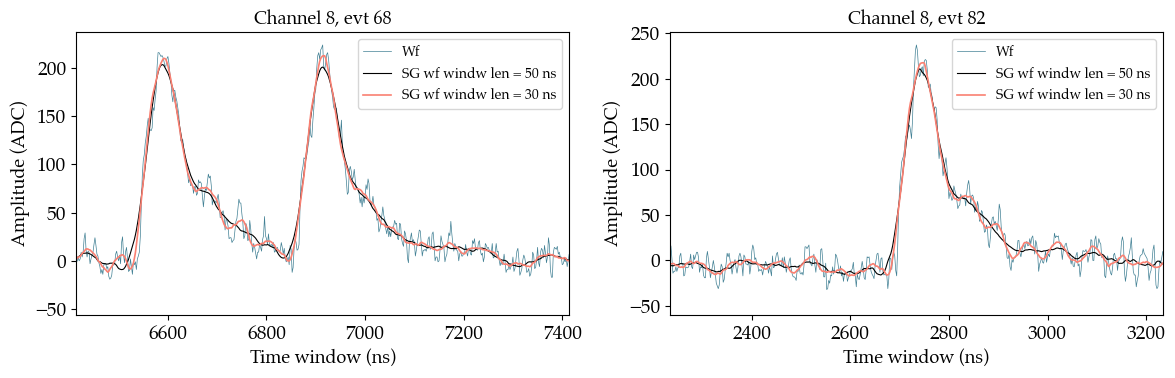

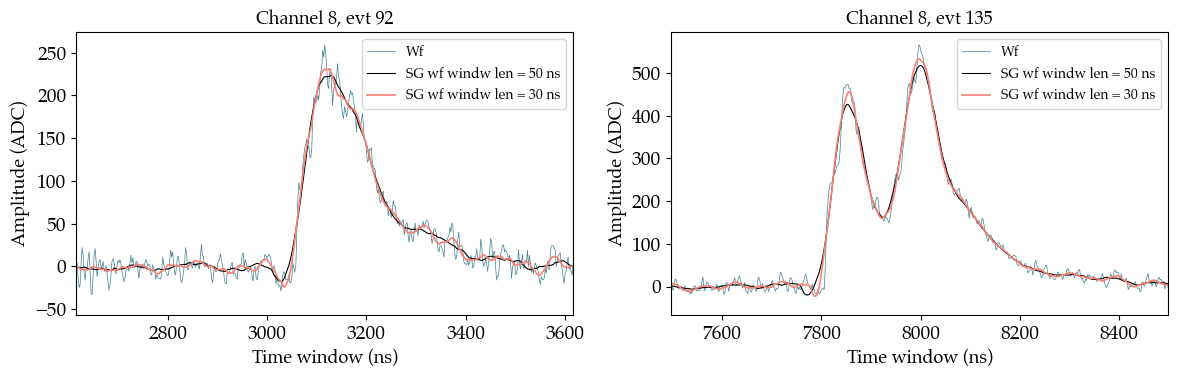

In [62]:
sel_ch     = 8
sel_events = [3, 4, 6, 10, 12, 18, 25, 31, 58, 60, 63, 67, 68, 82, 92, 135] #[3, 10, 18, 31]
for i in range(0, len(sel_events), 2):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    for evt, ax in zip([sel_events[i], sel_events[i+1]], axs.flatten()):
        swf     = subt_wfs_dict0     [sel_ch][evt]
        fswf    = sg_filt_swfs_dict0 [sel_ch][evt]
        fswf30  = sg_filt_swfs_dict30[sel_ch][evt]
        fswf20  = sg_filt_swfs_dict20[sel_ch][evt]
        max_idx = 2*np.argmax(swf)
        ax.plot(2*np.arange(len(swf)),    swf,    lw=0.5, label='Wf',                      c=fav_col)
        ax.plot(2*np.arange(len(fswf)),   fswf,   lw=0.8, label='SG wf windw len = 50 ns', c='k')
        ax.plot(2*np.arange(len(fswf30)), fswf30, lw=1.2, label='SG wf windw len = 30 ns', c='salmon')
        #ax.plot(2*np.arange(len(fswf20)), fswf20, lw=1.2, label='SG wf windw len = 20 ns', c='orange')
        ax.set_xlabel('Time window (ns)', fontsize=13)
        ax.set_ylabel('Amplitude (ADC)',  fontsize=13)
        ax.set_title(f"Channel {sel_ch}, evt {evt}", fontsize=13)
        ax.set_xlim(max_idx-500, max_idx+500)
        ax.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

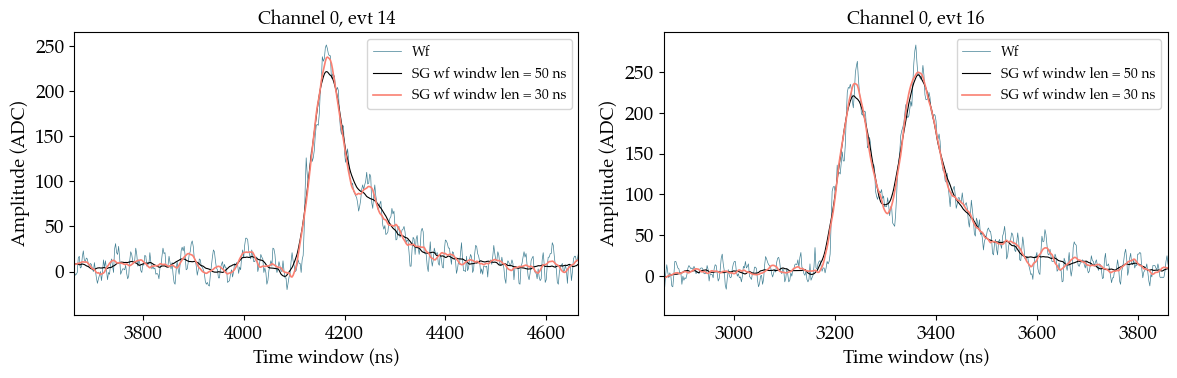

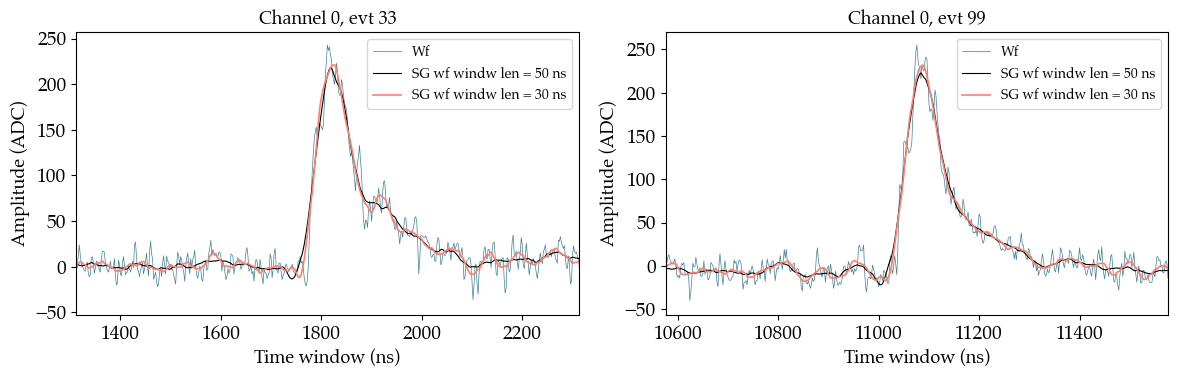

In [47]:
sel_ch     = 0
sel_events = [14, 16, 33, 99]
for i in range(0, len(sel_events), 2):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    for evt, ax in zip([sel_events[i], sel_events[i+1]], axs.flatten()):
        swf     = subt_wfs_dict0     [sel_ch][evt]
        fswf    = sg_filt_swfs_dict0 [sel_ch][evt]
        fswf30  = sg_filt_swfs_dict30[sel_ch][evt]
        fswf20  = sg_filt_swfs_dict20[sel_ch][evt]
        max_idx = 2*np.argmax(swf)
        ax.plot(2*np.arange(len(swf)),    swf,    lw=0.5, label='Wf',                      c=fav_col)
        ax.plot(2*np.arange(len(fswf)),   fswf,   lw=0.8, label='SG wf windw len = 50 ns', c='k')
        ax.plot(2*np.arange(len(fswf30)), fswf30, lw=1.2, label='SG wf windw len = 30 ns', c='salmon')
        #ax.plot(2*np.arange(len(fswf20)), fswf20, lw=1.2, label='SG wf windw len = 20 ns', c='orange')
        ax.set_xlabel('Time window (ns)', fontsize=13)
        ax.set_ylabel('Amplitude (ADC)',  fontsize=13)
        ax.set_title(f"Channel {sel_ch}, evt {evt}", fontsize=13)
        ax.set_xlim(max_idx-500, max_idx+500)
        ax.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

In [ ]:
sg_filt_swfs_dict30 = {ch: savgol_filter(subt_wfs_dict0[ch],
                                         window_length=30,
                                         polyorder=sg_filter_polyorder)
                     if len(subt_wfs_dict0[ch]) != 0 else []
                     for ch in normal_chs}

sg_filt_swfs_dict20 = {ch: savgol_filter(subt_wfs_dict0[ch],
                                         window_length=20,
                                         polyorder=sg_filter_polyorder)
                     if len(subt_wfs_dict0[ch]) != 0 else []
                     for ch in normal_chs}


trigg_cwfs_dict0 = {ch: np.array([blr.pmt_deconvolver(wf, wf_range_bsl=(0, max_smpl_bsl))
                                 for wf in pf.wfs_from_rawtree(RawTree2, ch)])
                   for ch in trigger_chs}

sg_filt_swfs_dict = {ch: savgol_filter(subt_wfs_dict[ch],
                                       window_length=sg_filter_window,
                                       polyorder=sg_filter_polyorder)
                     for ch in normal_chs}

sg_filt_trigg_dict = {ch: savgol_filter(trigg_cwfs_dict[ch],
                                        window_length=sg_filter_window,
                                        polyorder=sg_filter_polyorder)
                      for ch in trigger_chs}


thr_spe = 0.5
zs_sg_filt_swfs_dict = {ch: pf.noise_suppression(sg_filt_swfs_dict[ch]/gains_sg[ch],
                                                 threshold=thr_spe)
                        for ch in normal_chs}

zs_sg_filt_trigg_dict = {ch: pf.noise_suppression(sg_filt_trigg_dict[ch]/gains_sg[ch],
                                                  threshold=thr_spe)
                         for ch in trigger_chs}

In [ ]:
zs_sg_30_filt_swfs_dict = {ch: pf.noise_suppression(sg_filt_swfs_dict30[ch],
                                                 threshold=50)
                           for ch in normal_chs}

zs_sg_30_filt_trigg_dict = {ch: pf.noise_suppression(sg_filt_trigg_dict[ch]/gains_sg[ch],
                                                  threshold=thr_spe)
                         for ch in trigger_chs}

In [ ]:
_, idx_thr_sg_30_30, _, _, h_sgd_sg_30_30, _, idx_thr_trigg_sg_30_30, _, _, h_sgd_trigg_sg_30_30 = get_index_and_heights(subt_wfs_dict, zs_sg_filt_swfs_dict, trigg_cwfs_dict, zs_sg_filt_trigg_dict, thres=thr_spe, min_dist=30, thres_abs=True)


In [ ]:
fig = plt.figure(figsize=(8, 5))
h = plt.hist2d(np.concatenate(idx_peaks_ch)*2, np.concatenate(height_peaks_ch), bins=(500, 200), range=((0, 15000), (0, 1500)), cmin=1, norm=LogNorm())
plt.xlabel('Time window (ns)',      fontsize=14)
plt.ylabel('Amplitude peaks (ADC)', fontsize=14)
plt.colorbar(h[3], label='Counts', pad=0.02)
#plt.savefig('/Users/romoluque_c/LEGEND/BACON/Analysis_documentation/images/hit_map_example.pdf', bbox_inches='tight')
plt.show()

## Overlap waveforms to see the typical shape of the peaks

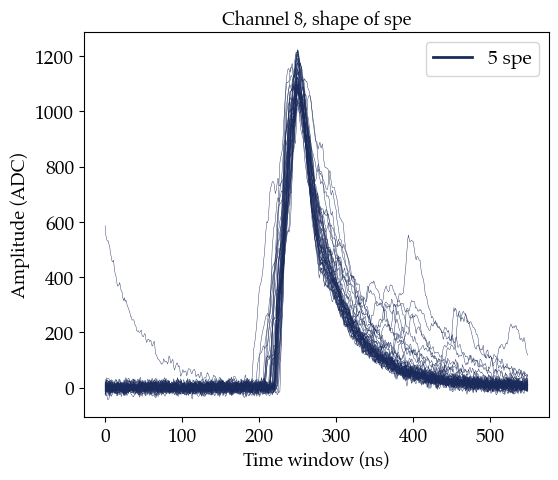

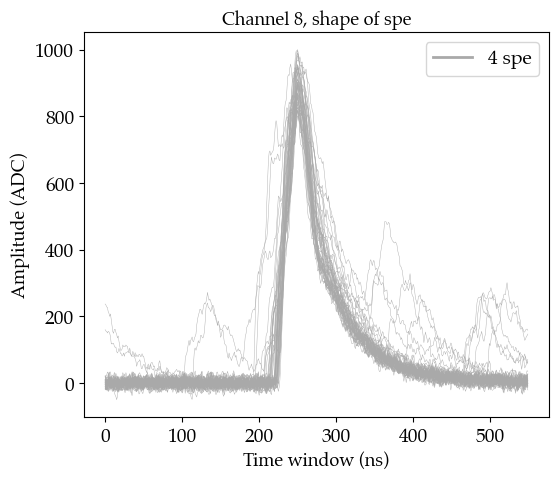

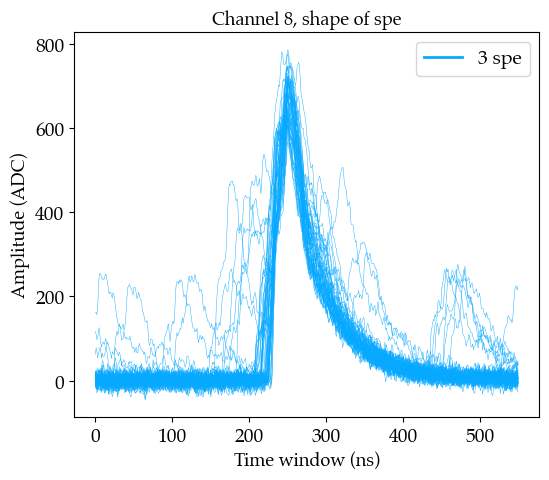

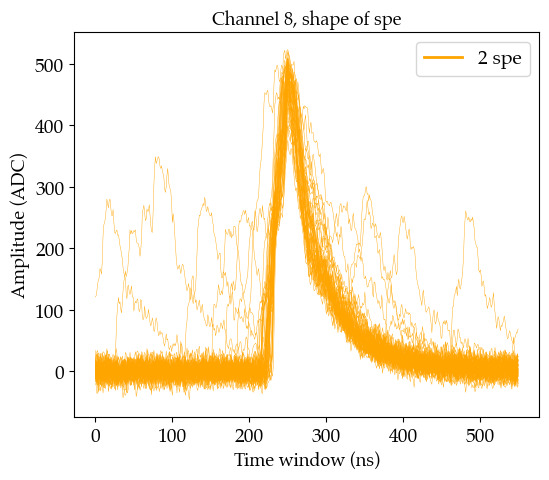

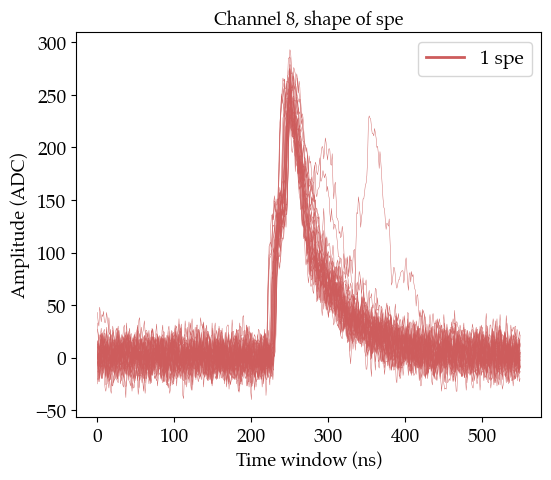

In [48]:
sel_ch     = 8
ievt       = 0
idx_range0 = 250
idx_range1 = 300
num_legend = 0
for nspe, num_evts, col in zip([5, 4, 3, 2, 1], [8000, 2000, 700, 200, 60], ['#1A2A5B', 'darkgrey', '#07A9FF', 'orange', 'indianred']):
    plt.figure(figsize=(6, 5))
    for evt in range(ievt, ievt+num_evts):
        swf     = subt_wfs_dict0[sel_ch][evt]
        max_val = np.max(swf)
        max_idx = np.argmax(swf)
        if np.std(swf)<15:
            continue
        
        minheight = gains[sel_ch]*(nspe - 0.5)
        maxheight = gains[sel_ch]*(nspe + 0.5)
        if max_val>minheight and max_val<maxheight:
            try:
                num_legend += 1
                if num_legend==1:
                    lab = f'{nspe} spe'
                else:
                    lab = ''
                plt.plot(np.arange(idx_range0+idx_range1), swf[max_idx-idx_range0: max_idx+idx_range1], lw=0.3, c=col, label=lab)
            except ValueError:
                continue
    num_legend = 0
    plt.xlabel('Time window (ns)', fontsize=13)
    plt.ylabel('Amplitude (ADC)',  fontsize=13)
    plt.title(f"Channel {sel_ch}, shape of spe", fontsize=13)
    leg = plt.legend()
    for line in leg.get_lines():
        line.set_linewidth(2)
    plt.show()

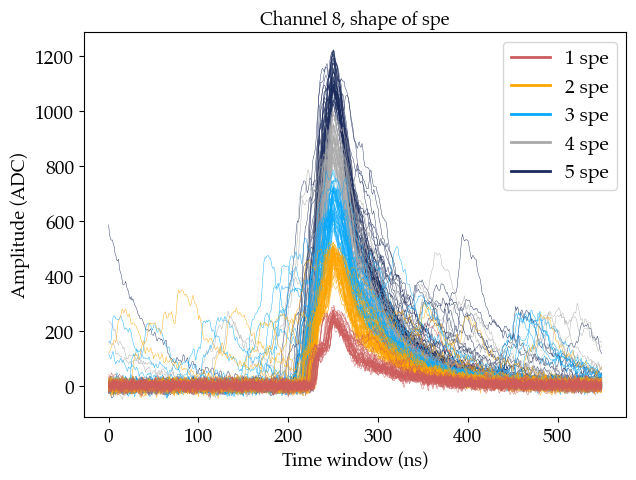

In [104]:
sel_ch     = 8
ievt       = 0
idx_range0 = 250
idx_range1 = 300
num_legend = 0
plt.figure(figsize=(7, 5))
for nspe, num_evts, col in zip([5, 4, 3, 2, 1], [8000, 2000, 600, 200, 60], ['#1A2A5B', 'darkgrey', '#07A9FF', 'orange', 'indianred']):
    for evt in range(ievt, ievt+num_evts):
        swf     = subt_wfs_dict0[sel_ch][evt]
        max_val = np.max(swf)
        max_idx = np.argmax(swf)
        if np.std(swf)<15:
            continue
        
        minheight = gains[sel_ch]*(nspe - 0.5)
        maxheight = gains[sel_ch]*(nspe + 0.5)
        if max_val>minheight and max_val<maxheight:
            try:
                num_legend += 1
                if num_legend==1:
                    lab = f'{nspe} spe'
                else:
                    lab = ''
                plt.plot(np.arange(idx_range0+idx_range1), swf[max_idx-idx_range0: max_idx+idx_range1], lw=0.3, c=col, label=lab)
            except ValueError:
                continue
    num_legend = 0
plt.xlabel('Time window (ns)', fontsize=13)
plt.ylabel('Amplitude (ADC)',  fontsize=13)
plt.title(f"Channel {sel_ch}, shape of spe", fontsize=13)

handles, labels = plt.gca().get_legend_handles_labels()
handles.reverse()
labels .reverse()
leg = plt.legend(handles, labels)
for line in leg.get_lines():
    line.set_linewidth(2)
#plt.savefig('/Users/romoluque_c/LEGEND/BACON/Analysis_documentation/images/spe_shape.pdf', bbox_inches='tight')
plt.show()

## Fit the single photoelectron

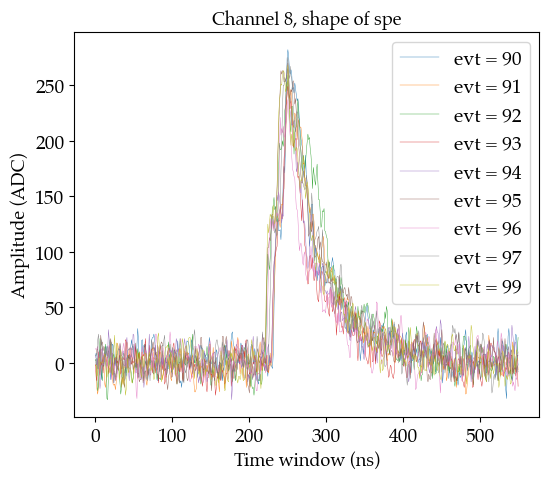

In [54]:
sel_ch     = 8
ievt       = 90
idx_range0 = 250
idx_range1 = 300
num_legend = 0
nspe       = 1
num_evts   = 10
col        = fav_col
minheight  = gains[sel_ch]*(nspe - 0.5)
maxheight  = gains[sel_ch]*(nspe + 0.5)
plt.figure(figsize=(6, 5))
for evt in range(ievt, ievt+num_evts):
    swf     = subt_wfs_dict0[sel_ch][evt]
    max_val = np.max(swf)
    max_idx = np.argmax(swf)
    if np.std(swf)<15:
        continue
    if max_val>minheight and max_val<maxheight:
        if len(np.arange(idx_range0+idx_range1))==len(swf[max_idx-idx_range0: max_idx+idx_range1]):
            plt.plot(np.arange(idx_range0+idx_range1), swf[max_idx-idx_range0: max_idx+idx_range1], lw=0.3,label=f'evt = {evt}')


plt.xlabel('Time window (ns)', fontsize=13)
plt.ylabel('Amplitude (ADC)',  fontsize=13)
plt.title(f"Channel {sel_ch}, shape of spe", fontsize=13)
plt.legend()
plt.show()

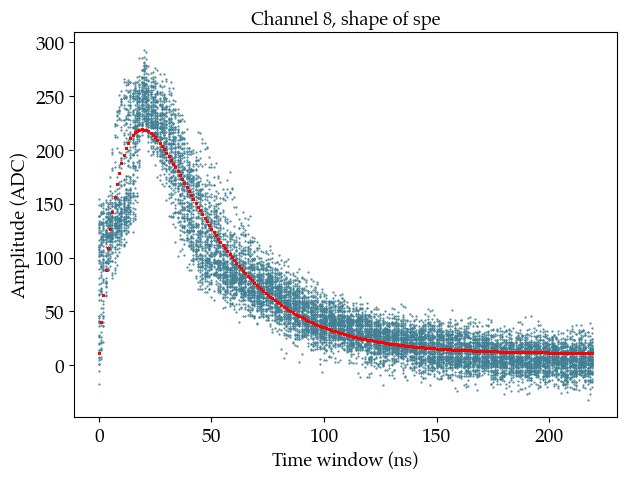

In [107]:
sel_ch     = 8
ievt       = 0
idx_range0 = 20
idx_range1 = 200
nspe       = 1
num_evts   = 100
minheight  = gains[sel_ch]*(nspe - 0.5)
maxheight  = gains[sel_ch]*(nspe + 0.5)
    
all_x_points = []
all_y_points = []
for evt in range(ievt, ievt+num_evts):
    swf     = subt_wfs_dict0[sel_ch][evt]
    max_val = np.max(swf)
    max_idx = np.argmax(swf)
    if evt in [10, 52, 58, 68]:
        continue
    if np.std(swf)<15:
        continue
    if max_val>minheight and max_val<maxheight:
        if len(np.arange(idx_range0+idx_range1))==len(swf[max_idx-idx_range0: max_idx+idx_range1]):
            all_x_points.append(np.arange(idx_range0+idx_range1))
            all_y_points.append(swf[max_idx-idx_range0: max_idx+idx_range1])

x = np.array(all_x_points).flatten()
y = np.array(all_y_points).flatten()
initial_guess = [250, 1/15, 1/200, 10]

def double_exp_decay(x, a, b, c, d):
    return a * (1 - np.exp(-b * x)) * np.exp(-c * x) + d

popt, pcov = curve_fit(double_exp_decay, x, y, p0=initial_guess)


plt.figure(figsize=(7, 5))
plt.scatter(x, y, s=0.3, c=fav_col)
plt.scatter(x, double_exp_decay(x, *popt), label='Fitted Model', c='r', s=1)
plt.xlabel('Time window (ns)', fontsize=13)
plt.ylabel('Amplitude (ADC)',  fontsize=13)
plt.title(f"Channel {sel_ch}, shape of spe", fontsize=13)
#plt.savefig('/Users/romoluque_c/LEGEND/BACON/Analysis_documentation/images/spe_shape_fit.pdf', bbox_inches='tight')
plt.show()

### Channel 0

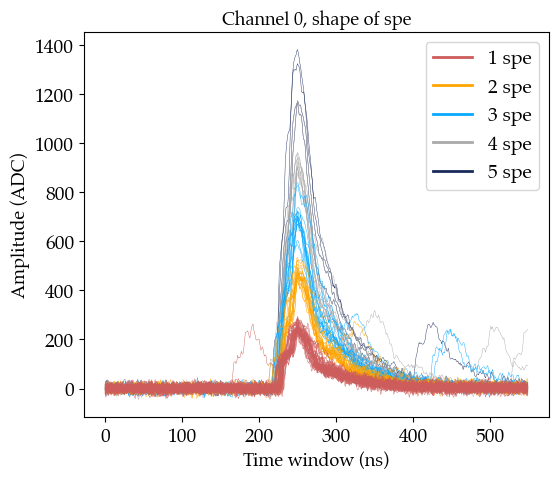

In [57]:
sel_ch     = 0
ievt       = 0
idx_range0 = 250
idx_range1 = 300
num_legend = 0
plt.figure(figsize=(6, 5))
for nspe, num_evts, minheight, maxheight, col in zip([5, 4, 3, 2, 1], [3000, 3000, 500, 150, 60], [1150, 850, 550, 300, 0], [1500, 1200, 900, 600, 300], ['#1A2A5B', 'darkgrey', '#07A9FF', 'orange', 'indianred']):
    for evt in range(ievt, ievt+num_evts):
        swf     = subt_wfs_dict0[sel_ch][evt]
        max_val = np.max(swf)
        max_idx = np.argmax(swf)
        if np.std(swf)<15:
            continue
        
        if max_val>minheight and max_val<maxheight:
            try:
                num_legend += 1
                if num_legend==1:
                    lab = f'{nspe} spe'
                else:
                    lab = ''
                plt.plot(np.arange(idx_range0+idx_range1), swf[max_idx-idx_range0: max_idx+idx_range1], lw=0.3, c=col, label=lab)
            except ValueError:
                continue
    num_legend = 0
plt.xlabel('Time window (ns)', fontsize=13)
plt.ylabel('Amplitude (ADC)',  fontsize=13)
plt.title(f"Channel {sel_ch}, shape of spe", fontsize=13)

handles, labels = plt.gca().get_legend_handles_labels()
handles.reverse()
labels .reverse()
leg = plt.legend(handles, labels)
for line in leg.get_lines():
    line.set_linewidth(2)
plt.show()

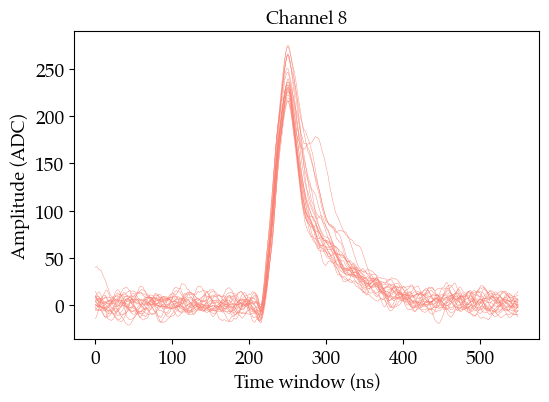

In [58]:
sel_ch     = 8
ievt       = 0
num_evts   = 40
idx_range0 = 250
idx_range1 = 300
plt.figure(figsize=(6, 4))
for evt in range(ievt, ievt+num_evts):
    swf     = sg_filt_swfs_dict30[sel_ch][evt]
    max_val = np.max(swf)
    max_idx = np.argmax(swf)
    if np.std(swf)<15 or max_val>300:
        continue
    try:
        plt.plot(np.arange(idx_range0+idx_range1), swf[max_idx-idx_range0: max_idx+idx_range1], lw=0.3, c='salmon')
    except ValueError:
        continue
plt.xlabel('Time window (ns)', fontsize=13)
plt.ylabel('Amplitude (ADC)',  fontsize=13)
plt.title(f"Channel {sel_ch}", fontsize=13)
plt.show()

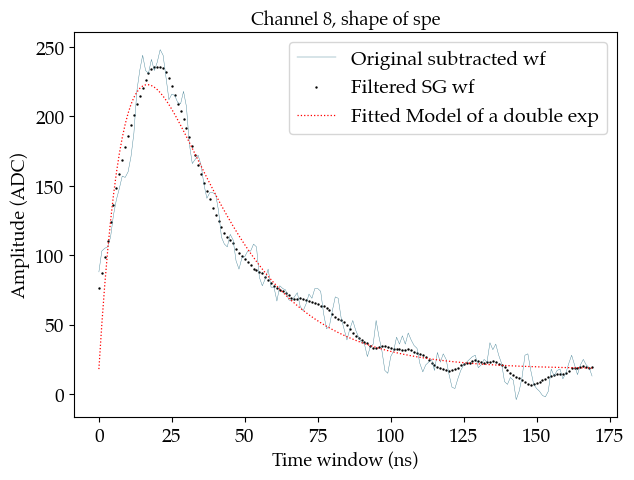

In [106]:
sel_ch     = 8
ievt       = 0
idx_range0 = 20
idx_range1 = 150
nspe       = 1
num_evts   = 1
minheight  = gains[sel_ch]*(nspe - 0.5)
maxheight  = gains[sel_ch]*(nspe + 0.5)
    
all_x_points = []
all_y_points = []

plt.figure(figsize=(7, 5))
for evt in range(ievt, ievt+num_evts):
    swf     = subt_wfs_dict0     [sel_ch][evt]
    fswf    = sg_filt_swfs_dict30[sel_ch][evt]
    max_val = np.max(fswf)
    max_idx = np.argmax(fswf)
    if evt in [10, 52, 58, 68]:
        continue
    if np.std(swf)<15:
        continue
    if max_val>minheight and max_val<maxheight:
        if len(np.arange(idx_range0+idx_range1))==len(fswf[max_idx-idx_range0: max_idx+idx_range1]):
            all_x_points.append(np.arange(idx_range0+idx_range1))
            all_y_points.append(fswf[max_idx-idx_range0: max_idx+idx_range1])
            plt.plot(np.arange(idx_range0+idx_range1), swf[max_idx-idx_range0: max_idx+idx_range1], lw=0.3, c=fav_col, label='Original subtracted wf')

x = np.array(all_x_points).flatten()
y = np.array(all_y_points).flatten()
initial_guess = [500, 1/15, 1/500, 10]

popt, pcov = curve_fit(double_exp_decay, x, y, p0=initial_guess)

plt.scatter(x, y, s=0.5, c='k', label='Filtered SG wf')
plt.plot(x, double_exp_decay(x, *popt), 'r:', lw=0.9, label='Fitted Model of a double exp')
plt.xlabel('Time window (ns)', fontsize=13)
plt.ylabel('Amplitude (ADC)',  fontsize=13)
plt.title(f"Channel {sel_ch}, shape of spe", fontsize=13)
plt.legend()
#plt.savefig('/Users/romoluque_c/LEGEND/BACON/Analysis_documentation/images/spe_shape_fit2.pdf', bbox_inches='tight')
plt.show()